## 1. Imports

In [37]:
import xarray as xr
import rioxarray
import geopandas as gpd
import rasterio as rio
from shapely.geometry import Polygon
import cdsapi
import regionmask

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import zipfile

import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

from utils.utils import convert_raster_to_vectors

In [2]:
# user inputs
download_climate_data = True
models = ["ACCESS-CM2", 
 'GFDL-ESM4',
 'INM-CM4-8',
 'INM-CM5-0',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'NESM3']

## 1. Data Imports

### 1.1 Historical Climate Data

In [3]:
#### monthly data

# download raw netCDF data 
c = cdsapi.Client()

if download_climate_data:
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'variable': [
                '2m_temperature',
                'total_precipitation',
                'surface_solar_radiation_downwards', # in cmip6: Surface downwelling shortwave radiation
            ],
            'year': [
                '1995', '1996', '1997',	
                '1998', '1999',
                '2000', '2001', '2002',
                '2003', '2004', '2005',
                '2006', '2007', '2008',
                '2009', '2010', '2011',
                '2012', '2013', '2014',
                '2015', '2016', '2017',
                '2018', '2019', '2020',
                '2021', '2022', '2023',
            ],
            'month': [
                '01', '02', '03', '04',
                '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'time': '00:00',
            'area': [
                40.5, 67.2, 6, 98.5  # North, West, South, East
            ],
        },
        r'data/climate/era5_monthly/era5_monthly.nc')



2024-02-09 14:11:20,182 INFO Welcome to the CDS
2024-02-09 14:11:20,183 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-02-09 14:11:20,381 INFO Request is queued
2024-02-09 16:31:59,061 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 0 of 500
2024-02-09 16:31:59,163 WARNING Retrying in 120 seconds
2024-02-09 16:33:59,168 INFO Retrying now...
2024-02-09 17:24:06,851 INFO Request is running
2024-02-09 17:28:07,408 INFO Request is completed
2024-02-09 17:28:07,411 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data4/adaptor.mars.internal-1707496049.1618035-10955-1-7f5d8769-374b-4813-b9d7-28aae9ac22e1.nc to data/climate/era5_monthly/era5_monthly.nc (58.7M)
2024-02-09 17:28:16,029 INFO Download rate 6.8M/s   


### 1.2 Climate Projections

In [4]:
c = cdsapi.Client()

def retrieve_cmip_data(model, variable):
    c.retrieve(
    'projections-cmip6',
    {
        'temporal_resolution': 'monthly',
        'experiment': 'ssp5_8_5',
        'variable': variable,
        'model': model,
        'year': [
            '2020', '2021', '2022',
            '2023', '2024', '2025',
            '2026', '2027', '2028',
            '2029', '2030', '2031',
            '2032', '2033', '2034',
            '2035', '2036', '2037',
            '2038', '2039', '2040',
            '2041', '2042', '2043',
            '2044', '2045', '2046',
            '2047', '2048', '2049',
            '2050', '2051', '2052',
            '2053', '2054', '2055',
            '2056', '2057', '2058',
            '2059', '2060', '2061',
            '2062', '2063', '2064',
            '2065', '2066', '2067',
            '2068', '2069', '2070',
            '2071', '2072', '2073',
            '2074', '2075', '2076',
            '2077', '2078', '2079',
            '2080', '2081', '2082',
            '2083', '2084', '2085',
            '2086', '2087', '2088',
            '2089', '2090', '2091',
            '2092', '2093', '2094',
            '2095', '2096', '2097',
            '2098', '2099', '2100',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'area': [
            40.5, 67.2, 6, 98.5  # North, West, South, East
        ],
        'format': 'zip',
    },
    f'data/climate/cmip_6_monthly/{model}_{variable}.zip')

In [5]:
c = cdsapi.Client()

def retrieve_cmip_historical_data(model, variable):
    c.retrieve(
    'projections-cmip6',
    {
        'temporal_resolution': 'monthly',
        'experiment': 'historical',
        'variable': variable,
        'model': model,
        'year': [
            '1995', '1996', '1997',	
            '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'area': [
            40.5, 67.2, 6, 98.5  # North, West, South, East
        ],
        'format': 'zip',
    },
    f'data/climate/cmip_6_monthly/{model}_{variable}_historical.zip')

In [6]:
if download_climate_data:
    for variable in ["near_surface_air_temperature", "precipitation", "surface_downwelling_shortwave_radiation"]:
        for model in models:
            try:
                retrieve_cmip_data(model, variable)
            except:
                print(f"Model {model} not found")

2024-02-09 17:28:16,286 INFO Welcome to the CDS
2024-02-09 17:28:16,288 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-02-09 17:28:16,408 INFO Request is queued
2024-02-09 17:28:17,483 INFO Request is running
2024-02-09 17:28:29,960 INFO Request is completed
2024-02-09 17:28:29,961 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.esgf_wps.retrieve-1707496106.9646294-18381-3-7a9c3c37-d119-486a-a0f3-0fd32c3729b4.zip to data/climate/cmip_6_monthly/ACCESS-CM2_near_surface_air_temperature.zip (1.4M)
2024-02-09 17:28:30,742 INFO Download rate 1.8M/s  
2024-02-09 17:28:30,868 INFO Welcome to the CDS
2024-02-09 17:28:30,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-02-09 17:28:30,996 INFO Request is queued
2024-02-09 17:28:32,071 INFO Request is running
2024-02-09 17:36:50,684 INFO Request is completed
2024-02-09 17:36:50,686 INFO D

In [7]:
if download_climate_data:
    for variable in ["near_surface_air_temperature", "precipitation", "surface_downwelling_shortwave_radiation"]:
        for model in models:
            try:
                retrieve_cmip_historical_data(model, variable)
            except:
                print(f"Model {model} not found")

2024-02-09 17:53:06,937 INFO Welcome to the CDS
2024-02-09 17:53:06,938 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-02-09 17:53:07,054 INFO Request is queued
2024-02-09 17:53:08,126 INFO Request is running
2024-02-09 17:53:20,609 INFO Request is completed
2024-02-09 17:53:20,611 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.esgf_wps.retrieve-1707497597.8307796-4666-6-561aa608-f499-49d0-80eb-2cb95b306d07.zip to data/climate/cmip_6_monthly/ACCESS-CM2_near_surface_air_temperature_historical.zip (511.2K)
2024-02-09 17:53:21,249 INFO Download rate 801.2K/s
2024-02-09 17:53:21,389 INFO Welcome to the CDS
2024-02-09 17:53:21,390 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-02-09 17:53:21,530 INFO Request is queued
2024-02-09 17:53:22,607 INFO Request is running
2024-02-09 17:53:35,077 INFO Request is completed
2024-02-09 17:53:3

In [8]:
# unzip the files
if download_climate_data:
    for variable in ["near_surface_air_temperature", "precipitation", "surface_downwelling_shortwave_radiation"]:
        for model in models:
            try:
                # unzip the file
                import zipfile

                with zipfile.ZipFile(f"data/climate/cmip_6_monthly/{model}_{variable}_historical.zip", 'r') as zip_ref:
                    zip_ref.extractall(f"data/climate/cmip_6_monthly/")
            except:
                print(f"Model {model} not found")

In [9]:
# unzip the files
if download_climate_data:
    for variable in ["near_surface_air_temperature", "precipitation", "surface_downwelling_shortwave_radiation"]:
        for model in models:
            try:
                # unzip the file
                import zipfile

                with zipfile.ZipFile(f"data/climate/cmip_6_monthly/{model}_{variable}.zip", 'r') as zip_ref:
                    zip_ref.extractall(f"data/climate/cmip_6_monthly/")
            except:
                print(f"Model {model} not found")

### 1.3 Shape Files

In [10]:
india_shapefile = gpd.read_file("data/shapefiles/geoBoundaries-IND-ADM0-all.zip")
india_districts_shapefile = gpd.read_file("data/shapefiles/gadm36_IND_2.shp")

## 2. Climate Data Bias Correction

In [11]:
era5_ds = xr.open_dataset("data/climate/era5_monthly/era5_monthly.nc")

era5_ds = era5_ds.sel(expver=1)
era5_ds = era5_ds.drop("expver")



# convert precipitation from m/day to m/month
month_length = era5_ds.time.dt.days_in_month
era5_ds['tp'] = era5_ds['tp'] * month_length

era5_ds


<xarray.Dataset>
Dimensions:    (longitude: 116, latitude: 127, time: 348)
Coordinates:
  * longitude  (longitude) float32 69.2 69.45 69.7 69.95 ... 97.45 97.7 97.95
  * latitude   (latitude) float32 38.5 38.25 38.0 37.75 ... 7.75 7.5 7.25 7.0
  * time       (time) datetime64[ns] 1995-01-01 1995-02-01 ... 2023-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float64 0.05763 0.06354 ... nan nan
    ssrd       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-09 16:27:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

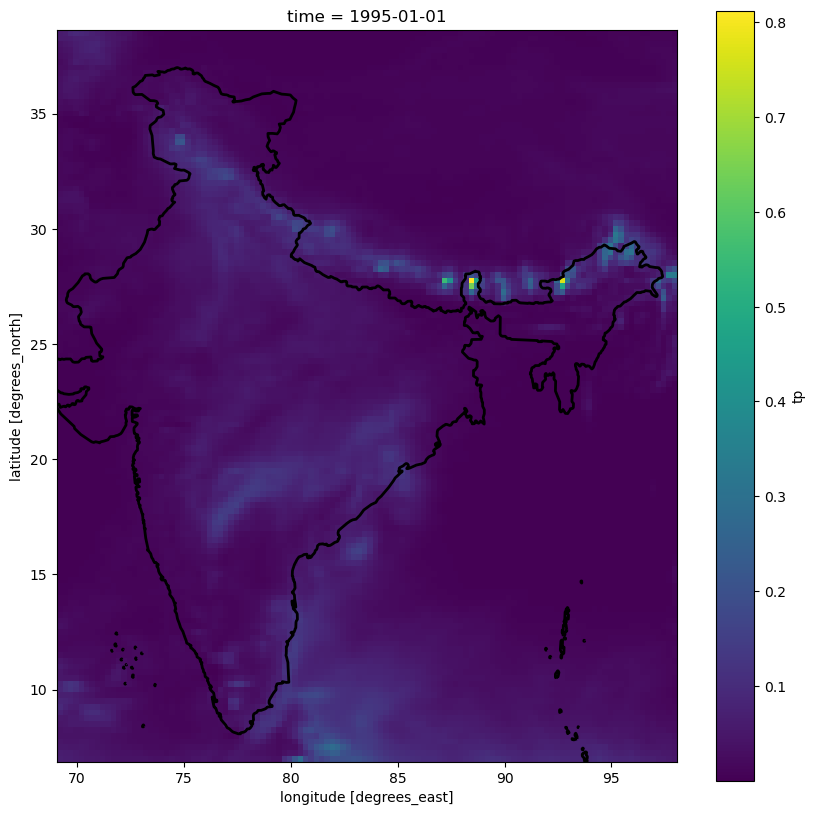

In [53]:
# plot with shapefile overlayed
fig, ax = plt.subplots(figsize=(10, 10))
era5_ds['tp'].isel(time=0).plot(ax=ax)
india_shapefile.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
plt.show()


In [12]:
import glob

y_def = [ 8.125,  9.375, 10.625, 11.875, 13.125, 14.375, 15.625, 16.875, 18.125,
       19.375, 20.625, 21.875, 23.125, 24.375, 25.625, 26.875, 28.125, 29.375,
       30.625, 31.875, 33.125, 34.375]
x_def = [68.4375, 70.3125, 72.1875, 74.0625, 75.9375, 77.8125, 79.6875, 81.5625,
       83.4375, 85.3125, 87.1875, 89.0625, 90.9375, 92.8125, 94.6875, 96.5625]

def load_climate_data_new(model, variable, scenario):
    # import and append all climate data
    file_pattern = f"data/climate/cmip_6_monthly/{variable}_Amon_{model}_{scenario}_r1i1p1f1_*.nc"
    file_list = glob.glob(file_pattern)

    data = xr.open_dataset(file_list[0])
    # print model resolution
    print(f"{model}: lon {data.lon.values[1] - data.lon.values[0]}, lat {data.lat.values[1] - data.lat.values[0]}")
    # time dimension into time stamp
    time_strings = data.time.dt.strftime('%Y-%m-%d').values
    # Convert to a list or a NumPy array, only year, remove month and day
    time_list = list(map(lambda x: x[:7], time_strings))
    #Use pd.to_datetime on the list
    data = data.assign_coords(time=pd.to_datetime(time_list))
    data = data.rename({'lat': 'y', 'lon': 'x'})

    data = data.interp(y=y_def, x= x_def, method='nearest')
    # data = data.sel(y=slice(south_bnd, north_bnd), x=slice(west_bnd, east_bnd))
    data = data[variable]
    return data

In [13]:
aggregate_df = pd.DataFrame(columns=['model', 'variable', 'time', 'value', 'region', 'scenario'])
variable_dict = {"tas": "t2m", "pr": "tp", "rsds": "ssrd"}

for scenario in ["ssp585", "historical"]:
    for variable in ["tas", "pr", "rsds"]:

        print(f"---  processing {variable}, {scenario}")
        i = 1
        if variable == "tas" and scenario == "ssp585":
            try:
                climate_data_aggregate = load_climate_data_new(models[0], variable, scenario).to_dataset(name=variable_dict[variable] + "_" + models[0] + "_" + scenario)
            except:
                climate_data_aggregate = load_climate_data_new(models[i], variable, scenario).to_dataset(name=variable_dict[variable] + "_" + models[i] + "_" + scenario)

                i += 1
        else:
            i = 0

        for model in models[i:]:
            try:
                climate_data_new = load_climate_data_new(model, variable, scenario).to_dataset(name=variable_dict[variable] + "_" + model + "_" + scenario)
                #climate_data_new = climate_data_new.expand_dims(dim='model').assign_coords(model=[model])
            except:
                print(f"could not load {model}, {variable}, {scenario}")
                continue
            
            climate_data_aggregate = xr.merge([climate_data_aggregate, climate_data_new])

---  processing tas, ssp585
ACCESS-CM2: lon 1.875, lat 1.25


GFDL-ESM4: lon 1.25, lat 1.0000000000000009
INM-CM4-8: lon 2.0, lat 1.5
INM-CM5-0: lon 2.0, lat 1.5
MIROC6: lon 1.40625, lat 1.400767374448031
MPI-ESM1-2-LR: lon 1.875, lat 1.8652592603139926
NESM3: lon 1.875, lat 1.8652610778808594
---  processing pr, ssp585
ACCESS-CM2: lon 1.875, lat 1.25
GFDL-ESM4: lon 1.25, lat 1.0000000000000009
INM-CM4-8: lon 2.0, lat 1.5
INM-CM5-0: lon 2.0, lat 1.5
MIROC6: lon 1.40625, lat 1.400767374448031
MPI-ESM1-2-LR: lon 1.875, lat 1.8652592603139926
NESM3: lon 1.875, lat 1.8652610778808594
---  processing rsds, ssp585
ACCESS-CM2: lon 1.875, lat 1.25
GFDL-ESM4: lon 1.25, lat 1.0000000000000009
INM-CM4-8: lon 2.0, lat 1.5
INM-CM5-0: lon 2.0, lat 1.5
MIROC6: lon 1.40625, lat 1.400767374448031
MPI-ESM1-2-LR: lon 1.875, lat 1.8652592603139926
NESM3: lon 1.875, lat 1.8652610778808594
---  processing tas, historical
ACCESS-CM2: lon 1.875, lat 1.25
GFDL-ESM4: lon 1.25, lat 1.0000000000000009
INM-CM4-8: lon 2.0, lat 1.5
INM-CM5-0: lon 2.0, lat 1.5
MIROC6: lon 1.406

In [14]:
for scenario in ["ssp585", "historical"]:
    for model in models:
        try:
            # convert precipitation from m/s to m/month
            month_length = climate_data_aggregate.time.dt.days_in_month
            climate_data_aggregate[f'tp_{model}_{scenario}'] = (climate_data_aggregate[f'tp_{model}_{scenario}'] * month_length * 60 * 60 * 24) / 1000

            # convert solar radiation from W/m2 to J/m2/day
            climate_data_aggregate[f'ssrd_{model}_{scenario}'] = climate_data_aggregate[f'ssrd_{model}_{scenario}'] * 60 * 60 * 24
        except:
            print(f"####### could not process {model}_{scenario}")

In [15]:
era5_monthly_means_ds = era5_ds.sel(time=slice('1995-01-01', '2014-12-31')).groupby('time.month').mean('time')
era5_monthly_means_ds = era5_monthly_means_ds.rename({'longitude': 'x', 'latitude': 'y'})
era5_monthly_means_ds = era5_monthly_means_ds.interp(x=climate_data_aggregate.x, y=climate_data_aggregate.y, method= "linear")
era5_monthly_means_ds 

<xarray.Dataset>
Dimensions:  (month: 12, y: 22, x: 16)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x        (x) float64 68.44 70.31 72.19 74.06 ... 90.94 92.81 94.69 96.56
  * y        (y) float64 8.125 9.375 10.62 11.88 ... 30.62 31.88 33.12 34.38
    height   float64 2.0
Data variables:
    t2m      (month, y, x) float64 nan 300.0 299.9 300.0 ... 259.2 257.1 254.9
    tp       (month, y, x) float64 nan 0.04456 0.02847 ... 0.007665 0.009617
    ssrd     (month, y, x) float64 nan 2.043e+07 ... 1.274e+07 1.278e+07

In [16]:
debiased_climate_data = xr.Dataset()
for model in models:
    try:
        for variable in ["t2m", "tp", "ssrd"]:
            model_dr = climate_data_aggregate[f'{variable}_{model}_historical']
            model_dr = model_dr.groupby('time.month').mean('time')
            # before computing the factor, we need to remove outliers, replac
            model_dr = model_dr.where(model_dr < model_dr.quantile(0.95), other = model_dr.quantile(0.95))
            model_dr = model_dr.where(model_dr > model_dr.quantile(0.05), other = model_dr.quantile(0.05))
            era5 = era5_monthly_means_ds[variable]
            era5 = era5.where(era5 < era5.quantile(0.95), other = era5.quantile(0.95))
            era5 = era5.where(era5 > era5.quantile(0.05), other = era5.quantile(0.05))
            
            factor_dr = era5/model_dr
            # clip factor to 0.05 to 25
            factor_dr = factor_dr.clip(min=factor_dr.quantile(0.05), max=factor_dr.quantile(0.95))
            for scenario in ["ssp585"]:
                scenario_data = climate_data_aggregate[f'{variable}_{model}_{scenario}']
                # Align the factor_dr with scenario_data by extracting month from scenario_data 'time' dimension
                # and using it to select the appropriate factor from factor_dr
                scenario_data_monthly = scenario_data.groupby('time.month')
                debiased_scenario_data = scenario_data_monthly.apply(lambda x: x * factor_dr.sel(month=x['time.month']))
                
                debiased_climate_data[f'{variable}_{model}_{scenario}'] = debiased_scenario_data
    except:
        print(f"could not process {model}")
            

## 3. Aggregate Climate Data by District

### 3.1 ERA5 by District

In [17]:
# convert temperature to celsius
era5_ds['t2m'] = era5_ds['t2m'] - 273.15


# 1. Create mask from shapefile and xarray era5_ds
mask = regionmask.from_geopandas(india_districts_shapefile, 
                                 names="GID_2", 
                                 abbrevs="_from_name").mask(era5_ds['longitude'],
                                                            era5_ds['latitude'])

# 2. Aggregate variables in the xarray using the mask
regional_agg_dr = era5_ds.groupby(mask).mean() # max, min, mapping custom functions also work



# 3. Convert the aggregated xarray to a dataframe
regional_agg = regional_agg_dr.to_dataframe()
regional_agg.reset_index(inplace=True)
regional_agg

,mask,time,t2m,tp,ssrd
0,1.0,1995-01-01,25.629646,0.006350,19432160.0
1,1.0,1995-02-01,25.399582,0.001377,22555660.0
2,1.0,1995-03-01,26.881577,0.023779,24228250.0
3,1.0,1995-04-01,28.573143,0.011730,24898860.0
4,1.0,1995-05-01,28.149826,0.194300,19638620.0
...,...,...,...,...,...
225847,665.0,2023-08-01,29.659948,0.461325,13319083.0
225848,665.0,2023-09-01,29.850214,0.340823,14946592.0
225849,665.0,2023-10-01,27.057545,0.176547,15300923.0
225850,665.0,2023-11-01,23.771631,0.001397,15373613.0


In [18]:
# add region information and drop mask column
regional_agg['GID_2'] = regional_agg.apply(lambda x: india_districts_shapefile['GID_2'][int(x['mask'])], axis=1)
regional_agg = regional_agg.drop(columns=['mask'])
# regional_agg = regional_agg.drop(columns=['crs'])




# Query to keep data up to end of 2022 
regional_agg = regional_agg.query('time < "2023-01-01"')



# merge to india districts shapefile
india_districts_weather = india_districts_shapefile.merge(regional_agg, on='GID_2')

# Keep only the columns GID_0, NAME_0, GID_1, NAME_1, GID_2, NAME_2, time, t2m, tp, region
india_districts_weather = india_districts_weather[['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'time', 't2m', 'tp', 'ssrd']]

india_districts_weather.head()

2024-02-09 18:09:29,018 INFO Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-02-09 18:09:29,021 INFO NumExpr defaulting to 8 threads.


,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,time,t2m,tp,ssrd
0,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-01-01,25.629646,0.006350,19432160.0
1,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-02-01,25.399582,0.001377,22555660.0
2,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-03-01,26.881577,0.023779,24228250.0
3,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-04-01,28.573143,0.011730,24898860.0
4,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-05-01,28.149826,0.194300,19638620.0


In [19]:
# Extract year and month from time column in india_districts_weather and query for years 2001 to 2020

# Extract years from datetime
india_districts_weather['year'] = pd.DatetimeIndex(india_districts_weather['time']).year 

# Extract months from dateime
india_districts_weather['month'] = pd.DatetimeIndex(india_districts_weather['time']).month

# Keep only relevant years and months
india_districts_weather = india_districts_weather.query('year >= 2000 and year <= 2020')
india_districts_weather = india_districts_weather.query('month >= 4 and month <= 11')

# give  the t2m and tp as rows for each month
india_districts_weather_pivot = india_districts_weather.pivot_table(index=['GID_2', 'year'], columns='month', values=['t2m', 'tp', 'ssrd'])

# Update dataframe to give t2m_5, t2m_6, t2m_7, t2m_8, t2m_9, t2m_10, t2m_11, tp_5, tp_6, tp_7, tp_8, tp_9, tp_10, tp_11
india_districts_weather_pivot.columns = ['_'.join(str(s).strip() for s in col if s) for col in india_districts_weather_pivot.columns]

# make india_districts_weather_pivot a normal dataframe
india_districts_weather_pivot = india_districts_weather_pivot.reset_index()

india_districts_weather_pivot


,GID_2,year,ssrd_4,ssrd_5,ssrd_6,ssrd_7,ssrd_8,ssrd_9,ssrd_10,ssrd_11,...,t2m_10,t2m_11,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,tp_10,tp_11
0,IND.1.2_1,2000,20654936.0,18085902.0,14867162.0,18418360.0,15090260.0,17085128.0,15273732.0,17833682.0,...,26.586449,26.962410,1.517596e-01,0.294644,0.284934,0.212423,0.408779,0.327343,0.342375,9.587470e-02
1,IND.1.2_1,2001,23818396.0,15962297.0,17021746.0,17957164.0,15923982.0,17922352.0,15852717.0,17690604.0,...,26.681961,26.781914,1.889295e-02,0.278094,0.242582,0.272989,0.351977,0.242348,0.305713,1.070349e-01
2,IND.1.2_1,2002,23616532.0,18535712.0,18130126.0,18045068.0,15849324.0,16756718.0,18265650.0,15298253.0,...,27.038277,26.910919,4.065293e-02,0.215068,0.205347,0.154309,0.277911,0.196942,0.219854,2.150129e-01
3,IND.1.2_1,2003,24994646.0,19340534.0,17827444.0,13629496.0,16369634.0,16888630.0,16642542.0,19154434.0,...,26.863853,27.651779,3.586253e-03,0.186599,0.217039,0.407119,0.333670,0.224782,0.254962,2.131177e-02
4,IND.1.2_1,2004,24359942.0,14809908.0,16049434.0,17316874.0,15565468.0,16926616.0,18118414.0,17863458.0,...,27.227356,27.423653,1.717455e-02,0.357352,0.333217,0.216129,0.330216,0.214705,0.187294,7.577707e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13624,IND.8.1_1,2016,25799250.0,24746152.0,18566364.0,10496252.0,11910602.0,13959438.0,17443204.0,19136920.0,...,27.074829,25.562103,2.241880e-04,0.010114,0.175425,0.451405,0.412340,0.340913,0.088706,1.117587e-07
13625,IND.8.1_1,2017,26488034.0,25177900.0,16730336.0,11745521.0,14597866.0,16895416.0,18519948.0,18360998.0,...,28.015015,25.398193,4.109368e-04,0.007798,0.299933,0.619437,0.451945,0.189097,0.080523,2.989545e-04
13626,IND.8.1_1,2018,26056286.0,26039208.0,17649444.0,9094601.0,13238250.0,18739764.0,20251760.0,18276926.0,...,29.067047,27.166718,1.117587e-07,0.000965,0.278565,0.630554,0.284183,0.058649,0.009110,2.989545e-04
13627,IND.8.1_1,2019,26245888.0,26469204.0,18343046.0,11520451.0,12041965.0,11093519.0,16288954.0,16531977.0,...,28.080353,26.826752,2.577603e-03,0.000965,0.211996,0.501008,0.600483,0.493064,0.104340,3.093101e-02


### 3.2 Climate Projections by District

In [20]:
for scenario in ["ssp585"]:
    for model in models:
        try:
            print(f"processing {model}_{scenario}")
            # convert temperature to celsius
            debiased_climate_data[f't2m_{model}_{scenario}'] = debiased_climate_data[f't2m_{model}_{scenario}'] - 273.15 
        except:
            print(f"####### could not process {model}_{scenario}")


processing ACCESS-CM2_ssp585
processing GFDL-ESM4_ssp585
processing INM-CM4-8_ssp585
processing INM-CM5-0_ssp585
processing MIROC6_ssp585
processing MPI-ESM1-2-LR_ssp585
processing NESM3_ssp585


In [21]:
climate_projections = debiased_climate_data

# interp climate projections to the same grid as era5
climate_projections = climate_projections.interp(x=era5_ds.longitude, y=era5_ds.latitude, method= "linear")

# remove x and y coordinates
climate_projections = climate_projections.drop(['x', 'y'])

climate_projections = climate_projections.rename({'longitude': 'x', 'latitude': 'y'})



# 1. Create mask from shapefile and xarray climate_projections
mask = regionmask.from_geopandas(india_districts_shapefile, 
                                names="GID_2", 
                                abbrevs="_from_name").mask(climate_projections['x'],
                                                            climate_projections['y'])

In [22]:
# 2. Aggregate variables in the xarray using the mask
regional_agg_dr = climate_projections.groupby(mask).mean() # max, min, mapping custom functions also work



# 3. Convert the aggregated xarray to a dataframe
regional_agg = regional_agg_dr.to_dataframe()
regional_agg.reset_index(inplace=True)



# add region information and drop mask column
regional_agg['GID_2'] = regional_agg.apply(lambda x: india_districts_shapefile['GID_2'][int(x['mask'])], axis=1)
regional_agg = regional_agg.drop(columns=['mask'])
# regional_agg = regional_agg.drop(columns=['crs'])




# merge to india districts shapefile
india_districts_projections = india_districts_shapefile[['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', ]].merge(regional_agg, on='GID_2')    

# Extract years from datetime
india_districts_projections['year'] = pd.DatetimeIndex(india_districts_projections['time']).year 

# Extract months from dateime
india_districts_projections['month'] = pd.DatetimeIndex(india_districts_projections['time']).month

india_districts_projections


,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,time,t2m_ACCESS-CM2_ssp585,tp_ACCESS-CM2_ssp585,ssrd_ACCESS-CM2_ssp585,...,ssrd_MIROC6_ssp585,t2m_MPI-ESM1-2-LR_ssp585,tp_MPI-ESM1-2-LR_ssp585,ssrd_MPI-ESM1-2-LR_ssp585,t2m_NESM3_ssp585,tp_NESM3_ssp585,ssrd_NESM3_ssp585,height,month,year
0,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-01-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,1995
1,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-02-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,1995
2,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-03-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3,1995
3,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-04-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4,1995
4,IND,India,IND.1_1,Andaman and Nicobar,IND.1.2_1,North and Middle Andaman,1995-05-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786583,IND,India,IND.36_1,West Bengal,IND.36.20_1,Uttar Dinajpur,2100-08-01,34.834646,0.428643,1.416414e+07,...,1.521704e+07,33.242548,0.219824,1.658414e+07,31.971670,0.456407,1.546622e+07,2.0,8,2100
786584,IND,India,IND.36_1,West Bengal,IND.36.20_1,Uttar Dinajpur,2100-09-01,32.656801,0.540783,1.432972e+07,...,1.529850e+07,30.259229,0.355251,1.441416e+07,31.773313,0.546369,1.471976e+07,2.0,9,2100
786585,IND,India,IND.36_1,West Bengal,IND.36.20_1,Uttar Dinajpur,2100-10-01,31.145636,0.231538,1.752449e+07,...,1.236422e+07,30.126376,0.145148,1.577338e+07,30.948073,0.144744,1.538920e+07,2.0,10,2100
786586,IND,India,IND.36_1,West Bengal,IND.36.20_1,Uttar Dinajpur,2100-11-01,28.198239,0.017125,1.530845e+07,...,1.422613e+07,27.857080,0.002553,1.557344e+07,27.944793,0.030480,1.481562e+07,2.0,11,2100


In [23]:
# give  the t2m and tp as rows for each month
india_districts_projections_pivot = india_districts_projections.pivot_table(index=['GID_2', 'year'], columns='month', values=list(debiased_climate_data.data_vars))

# Update dataframe to give t2m_5, t2m_6, t2m_7, t2m_8, t2m_9, t2m_10, t2m_11, tp_5, tp_6, tp_7, tp_8, tp_9, tp_10, tp_11
india_districts_projections_pivot.columns = ['_'.join(str(s).strip() for s in col if s) for col in india_districts_projections_pivot.columns]

# make india_districts_projections_pivot a normal dataframe
india_districts_projections_pivot = india_districts_projections_pivot.reset_index()

print(india_districts_projections_pivot.columns)

Index(['GID_2', 'year', 'ssrd_ACCESS-CM2_ssp585_1', 'ssrd_ACCESS-CM2_ssp585_2',
       'ssrd_ACCESS-CM2_ssp585_3', 'ssrd_ACCESS-CM2_ssp585_4',
       'ssrd_ACCESS-CM2_ssp585_5', 'ssrd_ACCESS-CM2_ssp585_6',
       'ssrd_ACCESS-CM2_ssp585_7', 'ssrd_ACCESS-CM2_ssp585_8',
       ...
       'tp_NESM3_ssp585_3', 'tp_NESM3_ssp585_4', 'tp_NESM3_ssp585_5',
       'tp_NESM3_ssp585_6', 'tp_NESM3_ssp585_7', 'tp_NESM3_ssp585_8',
       'tp_NESM3_ssp585_9', 'tp_NESM3_ssp585_10', 'tp_NESM3_ssp585_11',
       'tp_NESM3_ssp585_12'],
      dtype='object', length=254)


In [24]:
# Step 1: Melt the DataFrame
df_long = pd.melt(india_districts_projections_pivot, id_vars=['GID_2', 'year'], var_name='variable_model_month', value_name='value')

# Step 2: Extract variable, model, and month into separate columns
pattern = r'(\w+)_(.+?)_([^_]+)_(\d+)'

df_long[['variable', 'model', 'scenario', 'month']] = df_long['variable_model_month'].str.extract(pattern)

df_long.drop(columns=['variable_model_month'], inplace=True)

# in variable column: rename tas to t2m, pr to tp
df_long['variable'] = df_long['variable'] + "_" + df_long['month']

# filter months
df_long['month'] = pd.to_numeric(df_long['month'], errors='coerce')
df_long = df_long.query('month >= 4 and month <= 11')

# drop month column
df_long.drop(columns=['month'], inplace=True)

# Step 3: Pivot the DataFrame
projections_district_df = df_long.pivot_table(index=['GID_2', 'year', "model"], columns=['variable'], values='value').reset_index()

projections_district_df


variable,GID_2,year,model,ssrd_10,ssrd_11,ssrd_4,ssrd_5,ssrd_6,ssrd_7,ssrd_8,...,t2m_8,t2m_9,tp_10,tp_11,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9
0,IND.1.2_1,2020,ACCESS-CM2,1.599143e+07,1.745157e+07,2.253667e+07,1.949342e+07,1.754128e+07,1.498832e+07,1.613695e+07,...,27.557663,27.300947,0.253334,0.134369,1.322053e-02,0.032756,0.110579,0.753409,0.277144,0.436504
1,IND.1.2_1,2020,GFDL-ESM4,1.630106e+07,1.612151e+07,2.182267e+07,1.568930e+07,1.828282e+07,1.508338e+07,1.568654e+07,...,27.199680,26.892481,0.317144,0.282912,3.305190e-02,0.380103,0.314654,0.413513,0.385770,0.302695
2,IND.1.2_1,2020,INM-CM4-8,1.743961e+07,1.585615e+07,2.283938e+07,1.865254e+07,1.535829e+07,1.574808e+07,1.665449e+07,...,27.244869,27.213557,0.111650,0.218502,1.291926e-01,0.191959,0.321094,0.411559,0.283775,0.177075
3,IND.1.2_1,2020,INM-CM5-0,1.816555e+07,1.745982e+07,2.442783e+07,1.763203e+07,1.616724e+07,1.615175e+07,1.703296e+07,...,27.647735,27.388099,0.112108,0.195892,4.629465e-03,0.106368,0.386925,0.373266,0.227632,0.340721
4,IND.1.2_1,2020,MIROC6,2.022101e+07,1.608887e+07,2.404563e+07,2.198264e+07,1.667346e+07,1.575870e+07,1.357771e+07,...,27.409019,26.745256,0.150234,0.336647,2.271467e-03,0.038248,0.444343,0.440783,0.522480,0.364250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363766,IND.8.1_1,2100,INM-CM4-8,2.076622e+07,1.935053e+07,2.644156e+07,2.250125e+07,1.732020e+07,1.682013e+07,1.859727e+07,...,28.275517,29.465849,0.004349,0.000486,4.408418e-03,0.027943,1.066214,0.475649,0.253312,0.185625
363767,IND.8.1_1,2100,INM-CM5-0,1.908050e+07,1.847904e+07,2.405602e+07,2.354569e+07,1.913401e+07,1.612443e+07,1.625624e+07,...,28.137904,28.702768,0.014450,0.006752,7.927721e-03,0.008372,0.186246,0.371088,0.319903,0.517292
363768,IND.8.1_1,2100,MIROC6,2.069365e+07,1.734809e+07,2.777145e+07,2.343386e+07,2.347697e+07,8.626147e+06,1.423315e+07,...,27.783719,28.288306,0.004910,0.016309,5.270079e-04,0.059114,0.026193,0.509677,0.245754,0.318716
363769,IND.8.1_1,2100,MPI-ESM1-2-LR,1.864046e+07,1.829550e+07,2.582550e+07,2.630382e+07,1.528993e+07,1.621756e+07,1.648117e+07,...,28.401286,27.757193,0.028238,0.005772,8.671681e-07,0.000870,0.635355,0.780860,0.849346,0.438627


### 3.3 Merge Projections and ERA5

In [25]:
india_districts_weather_pivot["model"] = "ERA5"

india_districts_total_pivot = india_districts_weather_pivot.append(projections_district_df)

india_districts_total_pivot

,GID_2,year,ssrd_4,ssrd_5,ssrd_6,ssrd_7,ssrd_8,ssrd_9,ssrd_10,ssrd_11,...,t2m_11,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,tp_10,tp_11,model
0,IND.1.2_1,2000,2.065494e+07,1.808590e+07,1.486716e+07,1.841836e+07,1.509026e+07,1.708513e+07,1.527373e+07,1.783368e+07,...,26.962410,1.517596e-01,0.294644,0.284934,0.212423,0.408779,0.327343,0.342375,0.095875,ERA5
1,IND.1.2_1,2001,2.381840e+07,1.596230e+07,1.702175e+07,1.795716e+07,1.592398e+07,1.792235e+07,1.585272e+07,1.769060e+07,...,26.781914,1.889295e-02,0.278094,0.242582,0.272989,0.351977,0.242348,0.305713,0.107035,ERA5
2,IND.1.2_1,2002,2.361653e+07,1.853571e+07,1.813013e+07,1.804507e+07,1.584932e+07,1.675672e+07,1.826565e+07,1.529825e+07,...,26.910919,4.065293e-02,0.215068,0.205347,0.154309,0.277911,0.196942,0.219854,0.215013,ERA5
3,IND.1.2_1,2003,2.499465e+07,1.934053e+07,1.782744e+07,1.362950e+07,1.636963e+07,1.688863e+07,1.664254e+07,1.915443e+07,...,27.651779,3.586253e-03,0.186599,0.217039,0.407119,0.333670,0.224782,0.254962,0.021312,ERA5
4,IND.1.2_1,2004,2.435994e+07,1.480991e+07,1.604943e+07,1.731687e+07,1.556547e+07,1.692662e+07,1.811841e+07,1.786346e+07,...,27.423653,1.717455e-02,0.357352,0.333217,0.216129,0.330216,0.214705,0.187294,0.075777,ERA5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363766,IND.8.1_1,2100,2.644156e+07,2.250125e+07,1.732020e+07,1.682013e+07,1.859727e+07,1.891803e+07,2.076622e+07,1.935053e+07,...,30.519764,4.408418e-03,0.027943,1.066214,0.475649,0.253312,0.185625,0.004349,0.000486,INM-CM4-8
363767,IND.8.1_1,2100,2.405602e+07,2.354569e+07,1.913401e+07,1.612443e+07,1.625624e+07,1.761382e+07,1.908050e+07,1.847904e+07,...,29.400132,7.927721e-03,0.008372,0.186246,0.371088,0.319903,0.517292,0.014450,0.006752,INM-CM5-0
363768,IND.8.1_1,2100,2.777145e+07,2.343386e+07,2.347697e+07,8.626147e+06,1.423315e+07,1.552511e+07,2.069365e+07,1.734809e+07,...,28.227492,5.270079e-04,0.059114,0.026193,0.509677,0.245754,0.318716,0.004910,0.016309,MIROC6
363769,IND.8.1_1,2100,2.582550e+07,2.630382e+07,1.528993e+07,1.621756e+07,1.648117e+07,1.562091e+07,1.864046e+07,1.829550e+07,...,30.973172,8.671681e-07,0.000870,0.635355,0.780860,0.849346,0.438627,0.028238,0.005772,MPI-ESM1-2-LR


## 4. Yield Prediction

### 4.1 Data Preperation

In [26]:
yield_df = pd.read_csv("data/yield data/india_processed_yield.csv")

# Join df_yield and df_weather_pivot
yield_df.rename(columns={'Year': 'year'}, inplace=True)
df_yield_weather = yield_df.merge(india_districts_weather_pivot, on=['GID_2', 'year'], how='left')

df_yield_weather

,GID_2,State,District,year,Year End,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare),ssrd_4,...,t2m_11,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,tp_10,tp_11,model
0,IND.11.12_1,Gujarat,Gandhinagar,2000,2001,Kharif,7600.0,17100.0,2.250000,26968388.0,...,24.772522,7.476658e-05,0.008261,0.012402,0.258012,0.121594,0.008816,6.948672e-04,1.117587e-07,ERA5
1,IND.11.12_1,Gujarat,Gandhinagar,2001,2002,Kharif,7000.0,17500.0,2.500000,26492412.0,...,24.314056,1.083389e-03,0.003320,0.092345,0.227555,0.145257,0.010833,3.883311e-02,1.117587e-07,ERA5
2,IND.11.12_1,Gujarat,Gandhinagar,2002,2003,Kharif,4600.0,9900.0,2.152174,26636476.0,...,24.173401,2.278760e-03,0.000425,0.141393,0.039142,0.137575,0.037095,1.154840e-07,1.120716e-03,ERA5
3,IND.11.12_1,Gujarat,Gandhinagar,2003,2004,Kharif,13100.0,35200.0,2.687023,26343972.0,...,24.735962,1.120940e-04,0.000116,0.121482,0.445151,0.194281,0.030371,3.474914e-04,1.117587e-07,ERA5
4,IND.11.12_1,Gujarat,Gandhinagar,2004,2005,Kharif,13200.0,29100.0,2.204545,26407026.0,...,24.559875,1.117587e-07,0.010036,0.093241,0.206981,0.352006,0.025851,3.605376e-02,1.120940e-04,ERA5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,IND.7.9_1,Chhattisgarh,Dhamtari,2015,2016,Kharif,173361.0,314275.0,1.812836,23318928.0,...,24.011053,3.624301e-02,0.033012,0.279365,0.283350,0.324159,0.237795,1.600419e-02,8.667111e-04,ERA5
5116,IND.7.9_1,Chhattisgarh,Dhamtari,2016,2017,Kharif,183504.0,603476.0,3.288626,24323686.0,...,21.808863,1.371724e-02,0.014290,0.220910,0.403910,0.405917,0.368407,1.114577e-01,1.083367e-03,ERA5
5117,IND.7.9_1,Chhattisgarh,Dhamtari,2017,2018,Kharif,144868.0,311175.0,2.147990,25924832.0,...,22.558350,1.322463e-03,0.013024,0.218033,0.342016,0.272943,0.213326,1.322330e-01,3.399476e-03,ERA5
5118,IND.7.9_1,Chhattisgarh,Dhamtari,2018,2019,Kharif,178763.0,433106.0,2.422794,24166400.0,...,23.562115,1.847642e-02,0.018444,0.179220,0.391264,0.550865,0.197711,7.342034e-03,4.782155e-04,ERA5


In [27]:
# rename Yield (Tonnes/Hectare)	to Yield_t_ha
df_yield_weather.rename(columns={'Yield (Tonnes/Hectare)': 'Yield_t_ha', 'Area (Hectare)': 'Area_ha'}, inplace=True)
df_yield_weather = df_yield_weather.dropna()

# compute detrended yield
lm = smf.ols("Yield_t_ha ~ year", df_yield_weather).fit()
df_yield_weather['Yield_t_ha_detrended'] = df_yield_weather['Yield_t_ha'] - lm.predict(df_yield_weather) + lm.predict(df_yield_weather).mean()

df_yield_weather.head()

C:\Users\elias\AppData\Local\Temp\ipykernel_16968\2242845151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yield_weather['Yield_t_ha_detrended'] = df_yield_weather['Yield_t_ha'] - lm.predict(df_yield_weather) + lm.predict(df_yield_weather).mean()


,GID_2,State,District,year,Year End,Season,Area_ha,Production (Tonnes),Yield_t_ha,ssrd_4,...,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,tp_10,tp_11,model,Yield_t_ha_detrended
0,IND.11.12_1,Gujarat,Gandhinagar,2000,2001,Kharif,7600.0,17100.0,2.250000,26968388.0,...,7.476658e-05,0.008261,0.012402,0.258012,0.121594,0.008816,6.948672e-04,1.117587e-07,ERA5,2.564209
1,IND.11.12_1,Gujarat,Gandhinagar,2001,2002,Kharif,7000.0,17500.0,2.500000,26492412.0,...,1.083389e-03,0.003320,0.092345,0.227555,0.145257,0.010833,3.883311e-02,1.117587e-07,ERA5,2.781182
2,IND.11.12_1,Gujarat,Gandhinagar,2002,2003,Kharif,4600.0,9900.0,2.152174,26636476.0,...,2.278760e-03,0.000425,0.141393,0.039142,0.137575,0.037095,1.154840e-07,1.120716e-03,ERA5,2.400328
3,IND.11.12_1,Gujarat,Gandhinagar,2003,2004,Kharif,13100.0,35200.0,2.687023,26343972.0,...,1.120940e-04,0.000116,0.121482,0.445151,0.194281,0.030371,3.474914e-04,1.117587e-07,ERA5,2.902150
4,IND.11.12_1,Gujarat,Gandhinagar,2004,2005,Kharif,13200.0,29100.0,2.204545,26407026.0,...,1.117587e-07,0.010036,0.093241,0.206981,0.352006,0.025851,3.605376e-02,1.120940e-04,ERA5,2.386645


In [28]:
# train test split
train = df_yield_weather.query('year < 2016')
test = df_yield_weather.query('year >= 2016')



# Simplified model formula (start with this and then add more variables)
model_formula = "Yield_t_ha_detrended ~ "

# Now adapt formula with all column names from LAI May to Precipitation November
for col in df_yield_weather.columns[9:-1]:  # Adjusted indices to include the desired columns
    model_formula += col + " + "

# Remove the last extra ' + '
model_formula = model_formula.rstrip(' + ')

print(model_formula)

Yield_t_ha_detrended ~ ssrd_4 + ssrd_5 + ssrd_6 + ssrd_7 + ssrd_8 + ssrd_9 + ssrd_10 + ssrd_11 + t2m_4 + t2m_5 + t2m_6 + t2m_7 + t2m_8 + t2m_9 + t2m_10 + t2m_11 + tp_4 + tp_5 + tp_6 + tp_7 + tp_8 + tp_9 + tp_10 + tp_11 + model


### 4.2 Fit Model to Train and Test Set

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Yield_t_ha_detrended
No. Observations: 4062    Method:             ML                  
No. Groups:       252     Scale:              0.1139              
Min. group size:  14      Log-Likelihood:     -1949.5761          
Max. group size:  32      Converged:          Yes                 
Mean group size:  16.1                                            
--------------------------------------------------------------------
                Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------
Intercept        2.537      0.458    5.544   0.000    1.640    3.433
ssrd_4           0.000      0.000    2.772   0.006    0.000    0.000
ssrd_5           0.000      0.000    0.006   0.995   -0.000    0.000
ssrd_6          -0.000      0.000   -6.161   0.000   -0.000   -0.000
ssrd_7          -0.000      0.000   -2.222   0.026   -0.000   -

2024-02-09 18:20:38,980 WARNING No handles with labels found to put in legend.


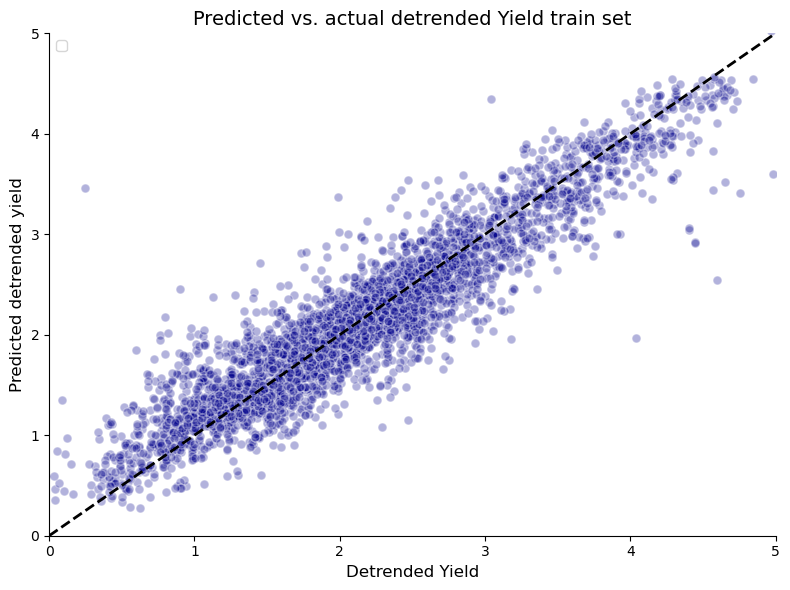

2024-02-09 18:20:39,572 WARNING No handles with labels found to put in legend.


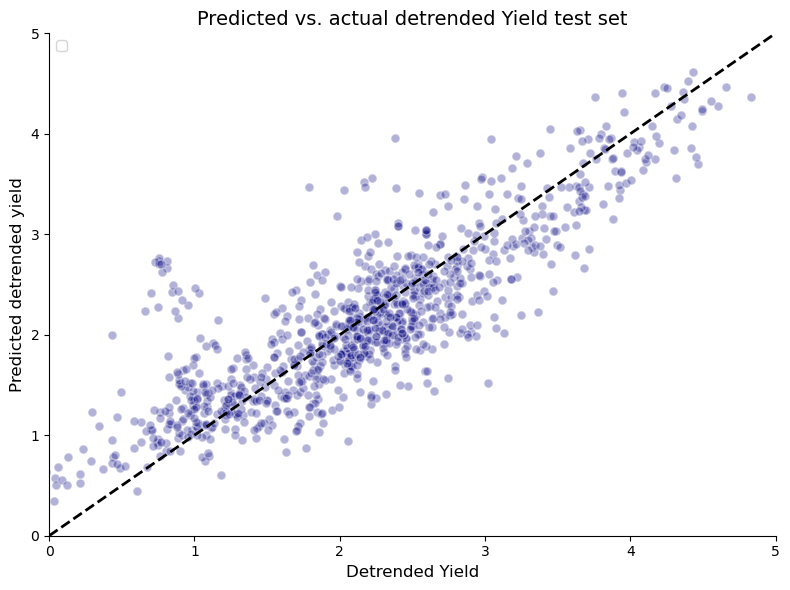

3953.1521803343567


In [30]:
# Fit the model
lm_test = smf.mixedlm(model_formula, train, groups=train["District"]).fit(reml=False)

# Print the model summary
print(lm_test.summary())


# Plot the predicted vs. actual detrended Yield
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(train['Yield_t_ha_detrended'], lm_test.fittedvalues, alpha=0.3, edgecolors='w', s=40, color='darkblue')
# add diagonal line
plt.plot([0, 5], [0, 5], color='black', lw=2, linestyle='--')
plt.xlim(0, 5)
plt.ylim(0, 5)
# Customize the plot
plt.xlabel('Detrended Yield', fontsize=12)
plt.ylabel('Predicted detrended yield', fontsize=12)
plt.title('Predicted vs. actual detrended Yield train set', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=10)
# Remove the top and right spines
sns.despine()
# Show the plot with a tight layout
plt.tight_layout()
plt.show()

# Plot the predicted vs. actual detrended Yield2
re = lm_test.random_effects
rev = [re[District].values[0] for District in test["District"]]
y_hat = lm_test.predict(test)+rev 

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(test['Yield_t_ha_detrended'], y_hat, alpha=0.3, edgecolors='w', s=40, color='navy')
# add diagonal line
plt.plot([0, 5], [0, 5], color='black', lw=2, linestyle='--')
plt.xlim(0, 5)
plt.ylim(0, 5)
# Customize the plot
plt.xlabel('Detrended Yield', fontsize=12)
plt.ylabel('Predicted detrended yield', fontsize=12)
plt.title('Predicted vs. actual detrended Yield test set', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=10)
# Remove the top and right spines
sns.despine()
# Show the plot with a tight layout
plt.tight_layout()
plt.show()

print(lm_test.aic)

### 4.3 Fit Model to Full Dataset

Yield_t_ha_detrended ~ ssrd_4 + ssrd_5 + ssrd_6 + ssrd_7 + ssrd_8 + ssrd_9 + ssrd_10 + ssrd_11 + t2m_4 + t2m_5 + t2m_6 + t2m_7 + t2m_8 + t2m_9 + t2m_10 + t2m_11 + tp_4 + tp_5 + tp_6 + tp_7 + tp_8 + tp_9 + tp_10 + tp_11


              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Yield_t_ha_detrended
No. Observations: 5082    Method:             ML                  
No. Groups:       254     Scale:              0.1268              
Min. group size:  18      Log-Likelihood:     -2568.5869          
Max. group size:  21      Converged:          Yes                 
Mean group size:  20.0                                            
--------------------------------------------------------------------
                Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------
Intercept        2.941      0.439    6.693   0.000    2.079    3.802
ssrd_4           0.000      0.000    3.196   0.001    0.000    0.000
ssrd_5          -0.000      0.000   -2.717   0.007   -0.000   -0.000
ssrd_6          -0.000      0.000   -6.151   0.000   -0.000   -0.000
ssrd_7          -0.000      0.000   -0.865   0.387   -0.000    

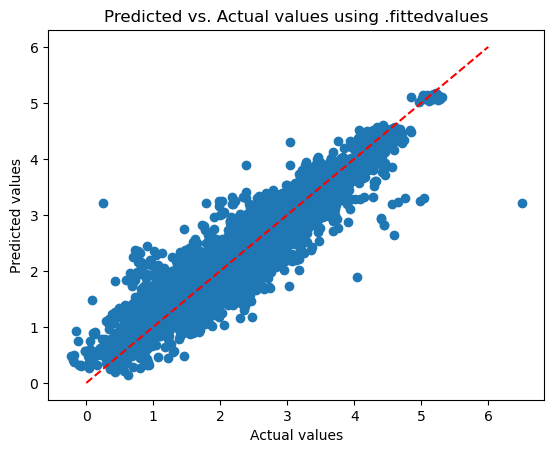

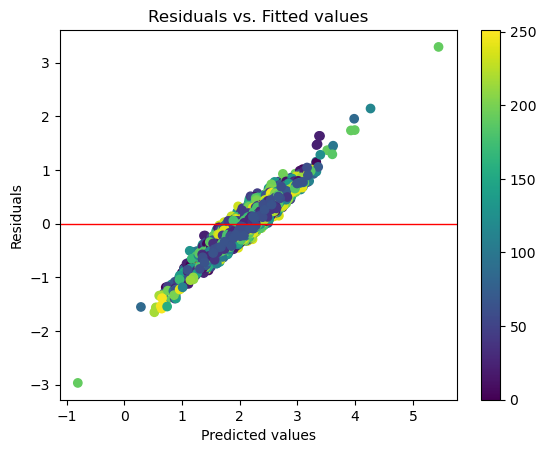

5191.17375921613


In [31]:
# Simplified model formula (start with this and then add more variables)
model_formula = "Yield_t_ha_detrended ~ "

# Now adapt formula with all column names from LAI May to Precipitation November
for col in df_yield_weather.columns[9:-2]:  # Adjusted indices to include the desired columns
    model_formula += col + " + "

# Remove the last extra ' + '
model_formula = model_formula.rstrip(' + ')

print(model_formula)


# Fit the model
lm = smf.mixedlm(model_formula, df_yield_weather, groups=df_yield_weather["GID_2"]).fit(reml = False)

# Print the model summary
print(lm.summary())

# # Plot the residuals
# plt.scatter(lm.predict(), lm.resid)
# plt.axhline(0, color='red', lw=1)
# plt.xlabel('Fitted values')
# plt.ylabel('Residuals')
# plt.title('Residuals vs. Fitted values')
# plt.show()

# Plot the predicted vs. actual values
plt.scatter(df_yield_weather['Yield_t_ha_detrended'], lm.fittedvalues)
plt.plot([0, 6], [0, 6], color = 'red', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values using .fittedvalues')
plt.show()

# plot prediction vs residuals, clolor by district
re = lm.random_effects
rev = [re[District].values[0] for District in df_yield_weather["GID_2"]]
y_hat = lm.predict(df_yield_weather) + rev
res = df_yield_weather['Yield_t_ha_detrended'] - y_hat
districts = df_yield_weather["District"].astype('category').cat.codes

# Now use these mapped numbers for coloring
plt.scatter(df_yield_weather['Yield_t_ha_detrended'] - rev, res, c=districts, cmap='viridis')  # 'viridis' is just an example colormap
plt.axhline(0, color='red', lw=1)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.colorbar()  # Optional: To show a color bar representing districts
plt.show()

print(lm.aic)

In [33]:
# count unique districts in the yield dataframe
n_districts = df_yield_weather['GID_2'].nunique()
n_districts

254

In [34]:
# simple measures for variables in the df_yield_weather dataframe
df_yield_weather.describe()


,year,Year End,Area_ha,Production (Tonnes),Yield_t_ha,ssrd_4,ssrd_5,ssrd_6,ssrd_7,ssrd_8,...,t2m_11,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,tp_10,tp_11,Yield_t_ha_detrended
count,5082.000000,5082.000000,5082.000000,5.082000e+03,5082.000000,5082.00,5082.0,5082.0,5082.00,5082.00,...,5082.000000,5.082000e+03,5.082000e+03,5082.000000,5082.000000,5082.000000,5082.000000,5.082000e+03,5.082000e+03,5082.000000
mean,2009.513577,2010.513577,68543.101338,1.638711e+05,2.152085,24026496.00,24273050.0,19815878.0,15091297.00,14902820.00,...,20.040405,5.286562e-02,7.417385e-02,0.199245,0.338971,0.288871,0.185600,6.904518e-02,2.157398e-02,2.152085
std,5.773484,5.773484,76814.976687,2.122800e+05,0.938805,2678192.75,3170062.5,3869172.0,2819397.25,2323549.50,...,5.153266,1.118708e-01,1.319269e-01,0.190530,0.210320,0.162385,0.136958,8.522772e-02,4.104205e-02,0.919235
min,2000.000000,2001.000000,2.000000,0.000000e+00,0.000000,11083886.00,10110568.0,8078371.0,7559396.50,8394432.00,...,-4.336990,1.117587e-07,1.154840e-07,0.000766,0.000765,0.006092,0.003085,1.154840e-07,1.117587e-07,-0.232539
25%,2005.000000,2006.000000,10297.000000,1.650475e+04,1.466937,23652375.50,23487114.0,16761119.0,13173718.50,13410423.00,...,18.917566,4.685455e-03,8.281663e-03,0.068287,0.197493,0.176745,0.087486,6.243830e-03,4.692402e-04,1.510732
50%,2010.000000,2011.000000,38956.500000,8.297200e+04,2.126500,24823041.00,25391002.0,20326857.0,14926894.50,14816919.00,...,21.013550,1.331522e-02,2.245320e-02,0.132941,0.301724,0.262508,0.152215,3.155567e-02,4.205289e-03,2.119670
75%,2015.000000,2016.000000,108356.250000,2.475702e+05,2.672932,25601712.50,26360383.0,23009577.0,16789340.00,16411094.75,...,22.988201,4.435897e-02,6.584851e-02,0.272471,0.427618,0.365414,0.253443,1.050743e-01,2.402164e-02,2.640215
max,2020.000000,2021.000000,545965.000000,1.710000e+06,6.315789,27669978.00,29575738.0,28270786.0,25613202.00,22312808.00,...,27.714817,1.333259e+00,1.363963e+00,1.258427,1.684681,1.433424,1.154821,5.503632e-01,4.205304e-01,6.497889


### 4.4 Visualize Parameter Estimates

In [32]:

# Assuming `df_yield_weather` is your original DataFrame

n_bootstraps = 1000
bootstrap_estimates = []
unique_years = df_yield_weather['year'].unique()

for _ in range(n_bootstraps):
    print(_)
    sampled_years = np.random.choice(unique_years, size=len(unique_years), replace=True)
    
    # Include all data from the sampled years
    df_bootstrap = df_yield_weather[df_yield_weather['year'].isin(sampled_years)]

    # Fit the model on the bootstrap sample
    lm_bootstrap = smf.mixedlm(model_formula, df_bootstrap, groups=df_bootstrap["GID_2"]).fit(reml=False)

    # Collect fixed effects estimates
    bootstrap_estimates.append(lm_bootstrap.fe_params)

# Convert the list of Series into a DataFrame
df_bootstrap_estimates = pd.DataFrame(bootstrap_estimates)

# Compute mean and confidence intervals of the estimates
fixed_effects_bootstrap = pd.DataFrame({
    'Estimate': df_bootstrap_estimates.mean(),
    'Lower CI': df_bootstrap_estimates.quantile(0.025),
    'Upper CI': df_bootstrap_estimates.quantile(0.975)
}).reset_index()

# Follow similar steps to adjust the DataFrame for plotting
fixed_effects_bootstrap.columns = ['Variable', 'Estimate', 'Lower CI', 'Upper CI']


# Convert df_bootstrap_estimates back for easier plotting of individual estimates
bootstrap_estimates_long = pd.melt(df_bootstrap_estimates, var_name='Variable', value_name='Estimate')



0
1
2
3
4
5
6


KeyboardInterrupt: 

C:\Users\elias\AppData\Local\Temp\ipykernel_12556\4220919687.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_effects,


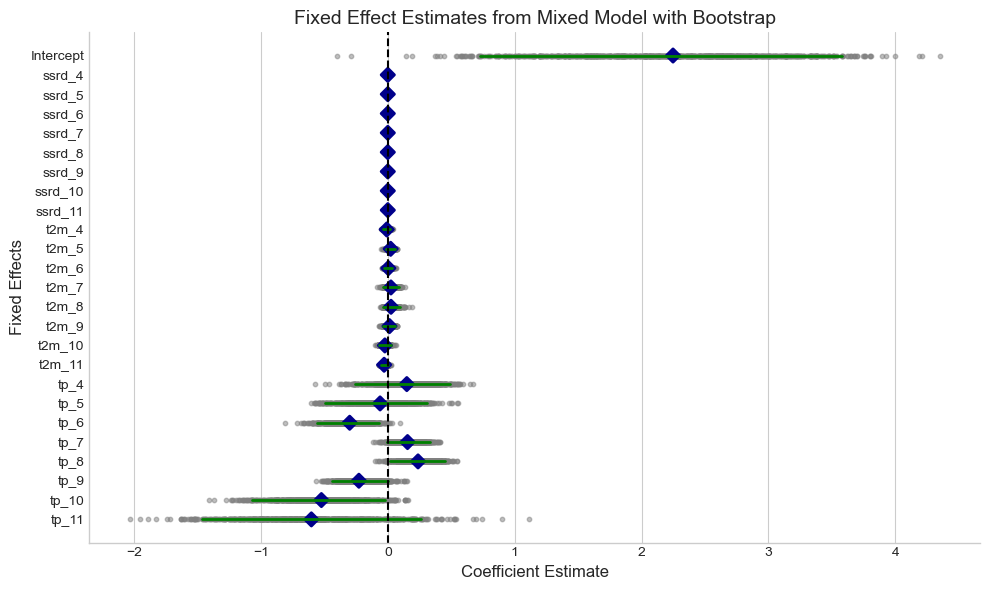

In [ ]:
def plot_fixed_effects_with_bootstrap(subset_fixed_effects, bootstrap_estimates):
    plt.figure(figsize=(10, 6))

    # Plot individual bootstrapped estimates as grey dots
    for variable in subset_fixed_effects['Variable']:
        estimates = bootstrap_estimates[bootstrap_estimates['Variable'] == variable]['Estimate']
        y = [variable] * len(estimates)
        plt.scatter(estimates, y, color='grey', alpha=0.5, s=10)

    # Now plot the mean estimates with confidence intervals as before
    sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_effects,
                  join=False, capsize=0.1, color='darkblue', markers='D',
                  errwidth=1, ci=None)

    # plot confidence interval
    for i in range(subset_fixed_effects.shape[0]):
        plt.plot([subset_fixed_effects['Lower CI'].iloc[i], subset_fixed_effects['Upper CI'].iloc[i]], [i, i], color='green', linewidth=2)
    

    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel('Coefficient Estimate', fontsize=12)
    plt.ylabel('Fixed Effects', fontsize=12)
    plt.title('Fixed Effect Estimates from Mixed Model with Bootstrap', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Convert df_bootstrap_estimates back for easier plotting of individual estimates
bootstrap_estimates_long = pd.melt(df_bootstrap_estimates, var_name='Variable', value_name='Estimate')

# Plotting different subsets if needed or plot all at once
plot_fixed_effects_with_bootstrap(fixed_effects_bootstrap, bootstrap_estimates_long)


C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='month', inplace=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_

###########
ssrd_4
###########
ssrd_5
###########
ssrd_6
###########
ssrd_7
###########
ssrd_8
###########
ssrd_9
###########
ssrd_10
###########
ssrd_11


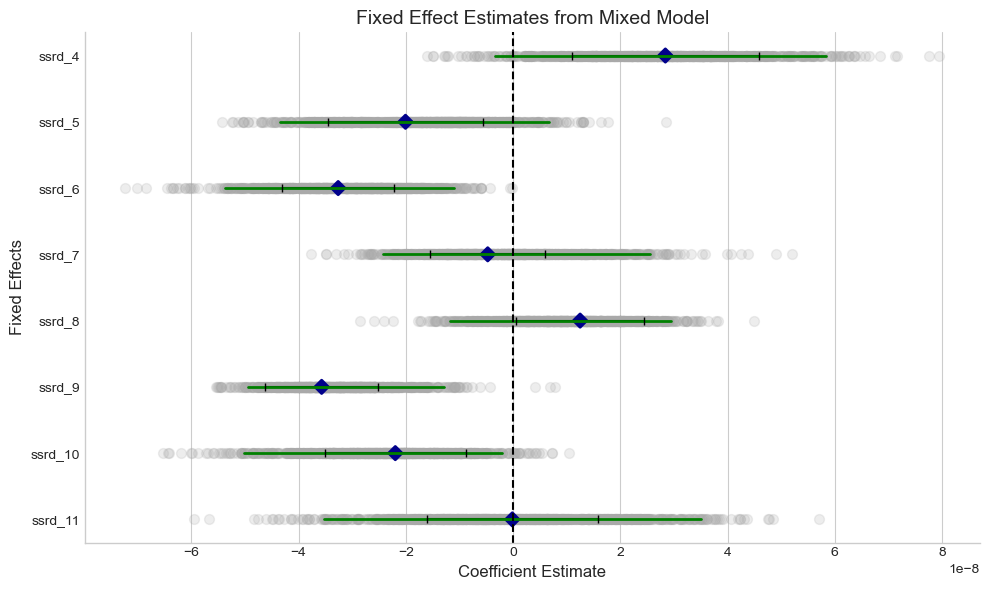

C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='month', inplace=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_

###########
t2m_4
###########
t2m_5
###########
t2m_6
###########
t2m_7
###########
t2m_8
###########
t2m_9
###########
t2m_10
###########
t2m_11


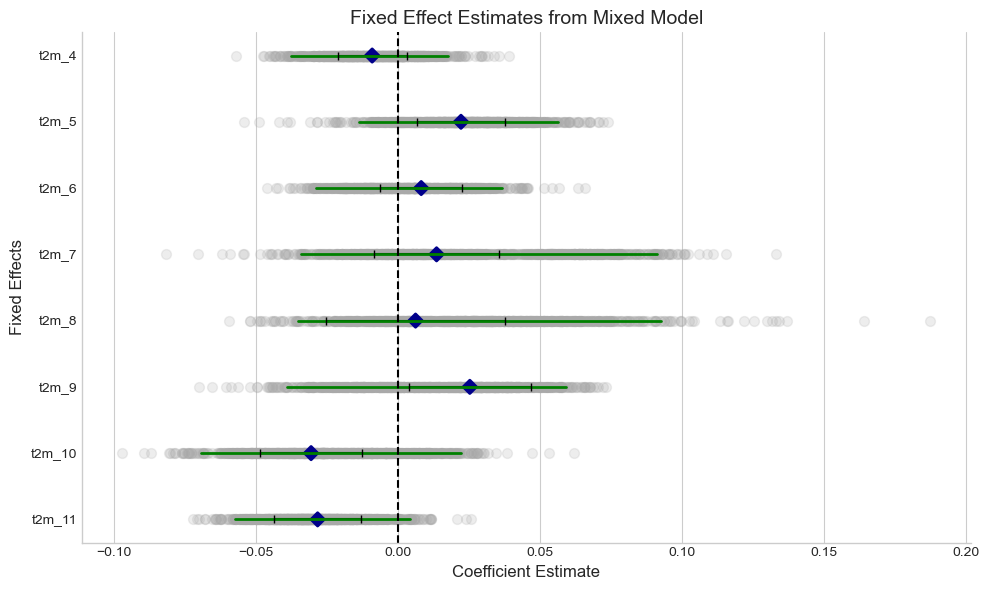

C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='month', inplace=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_12556\2038486631.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_

###########
tp_4
###########
tp_5
###########
tp_6
###########
tp_7
###########
tp_8
###########
tp_9
###########
tp_10
###########
tp_11


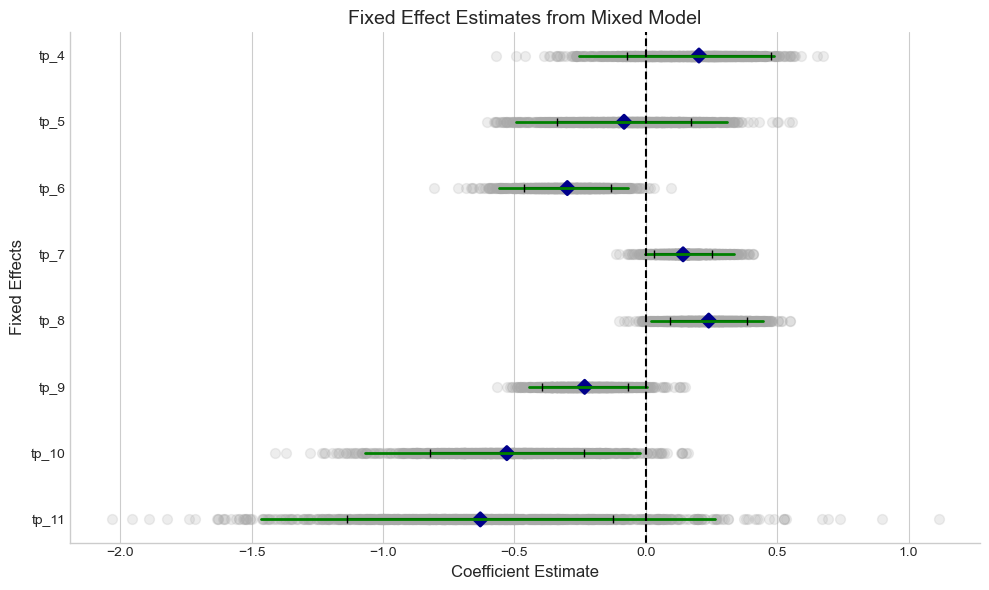

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'lm' is your mixed effects model object and it has a method to get the summary dataframe
# For example, using statsmodels it would look something like this:
# fixed_effects = lm.fe_params
# conf_int = lm.conf_int()


# Here's a mock-up of how you might retrieve the data
fixed_effects = pd.DataFrame({
    'Estimate': lm.fe_params,
    #"p value": lm.p_values,
    'Lower CI': lm.conf_int()[0],
    'Upper CI': lm.conf_int()[1]
})

# Reset index to get the variable names into a column
fixed_effects.reset_index(inplace=True)
fixed_effects.columns = ['Variable', 'Estimate', 'Lower CI', 'Upper CI'] #'p value' 

# Set the style for the plot
plt.style.use('seaborn-whitegrid')



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'lm' is your mixed effects model object
# ...

# Function to create the dot-and-whisker plot
def plot_fixed_effects(subset_fixed_effects):
    # Add month column by extracting month from variable, split by _ and convert to int
    subset_fixed_effects['month'] = subset_fixed_effects['Variable'].str.split('_').str[1].astype(int)
    # Sort by month
    subset_fixed_effects.sort_values(by='month', inplace=True)

    plt.figure(figsize=(10, 6))
    
    for variable in subset_fixed_effects['Variable'].unique():
        print("###########")
        print(variable)
        estimates = bootstrap_estimates_long[bootstrap_estimates_long['Variable'] == variable]['Estimate']
        y = [variable] * len(estimates)
        plt.scatter(estimates, y, color='darkgrey', alpha=0.2, s=50)

    for i in range(subset_fixed_effects.shape[0]):
        plt.plot([fixed_effects_bootstrap[fixed_effects_bootstrap['Variable'] == subset_fixed_effects['Variable'].iloc[i]]['Lower CI'].values[0],
                    fixed_effects_bootstrap[fixed_effects_bootstrap['Variable'] == subset_fixed_effects['Variable'].iloc[i]]['Upper CI'].values[0]],
                     [i, i], color='green', linewidth=2)
    
    # Create the dot-and-whisker plot
    
    sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_effects,
                  join=False, capsize=0.1, color='darkblue', markers='D',
                  errwidth=1, ci=None)

    # Draw the error bars manually
    # Draw the error bars manually since sns.pointplot doesn't support asymmetric error bars
    for index, row in subset_fixed_effects.iterrows():
        plt.errorbar(x=row['Estimate'], y=index, xerr=[[row['Estimate'] - row['Lower CI']], [row['Upper CI'] - row['Estimate']]],
                    fmt='none', c='black', capsize=3)

        # Plot individual bootstrapped estimates as grey dots
    





    # Add horizontal line at zero
    plt.axvline(x=0, color='black', linestyle='--')

    # Customize the plot
    plt.xlabel('Coefficient Estimate', fontsize=12)
    plt.ylabel('Fixed Effects', fontsize=12)
    plt.title('Fixed Effect Estimates from Mixed Model', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Here's a mock-up of how you might retrieve the data
fixed_effects = pd.DataFrame({
    'Estimate': lm.fe_params,
    'Lower CI': lm.conf_int()[0],
    'Upper CI': lm.conf_int()[1]
})

# Reset index to get the variable names into a column
fixed_effects.reset_index(inplace=True)
fixed_effects.columns = ['Variable', 'Estimate', 'Lower CI', 'Upper CI']

# Plotting different subsets
slices = [(2, 10), (10, 18), (18, None)]  # Define slices as tuples (start, end)
for start, end in slices:
    subset = fixed_effects.iloc[start:end] if end is not None else fixed_effects.iloc[start:]
    subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
    subset.sort_values(by='month', inplace=True)
    subset = subset.reset_index()
    plot_fixed_effects(subset)









In [ ]:
bootstrap_estimates#[bootstrap_estimates['Variable'] == variable]['Estimate']

[Intercept    2.398391e+00
 ssrd_4       3.906215e-08
 ssrd_5      -1.444505e-08
 ssrd_6      -3.195382e-08
 ssrd_7      -1.517384e-09
 ssrd_8       5.724247e-09
 ssrd_9      -3.425737e-08
 ssrd_10     -3.937125e-08
 ssrd_11     -1.888102e-09
 t2m_4        5.807583e-03
 t2m_5        6.196640e-03
 t2m_6        1.014696e-03
 t2m_7        5.779139e-03
 t2m_8        4.293948e-02
 t2m_9        3.277396e-02
 t2m_10      -4.383390e-02
 t2m_11      -2.266021e-02
 tp_4         2.445908e-01
 tp_5        -8.263486e-02
 tp_6        -1.805112e-01
 tp_7         2.032768e-01
 tp_8         1.553586e-01
 tp_9        -1.555826e-01
 tp_10       -5.482993e-01
 tp_11       -5.287026e-01
 dtype: float64,
 Intercept    2.371828e+00
 ssrd_4       7.728361e-09
 ssrd_5       5.984037e-10
 ssrd_6      -5.157244e-08
 ssrd_7       5.263185e-09
 ssrd_8      -8.437840e-09
 ssrd_9      -1.166415e-08
 ssrd_10     -2.918574e-08
 ssrd_11     -1.800419e-08
 t2m_4       -1.047603e-02
 t2m_5       -1.523323e-03
 t2m_6     

C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='month', inplace=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_ef

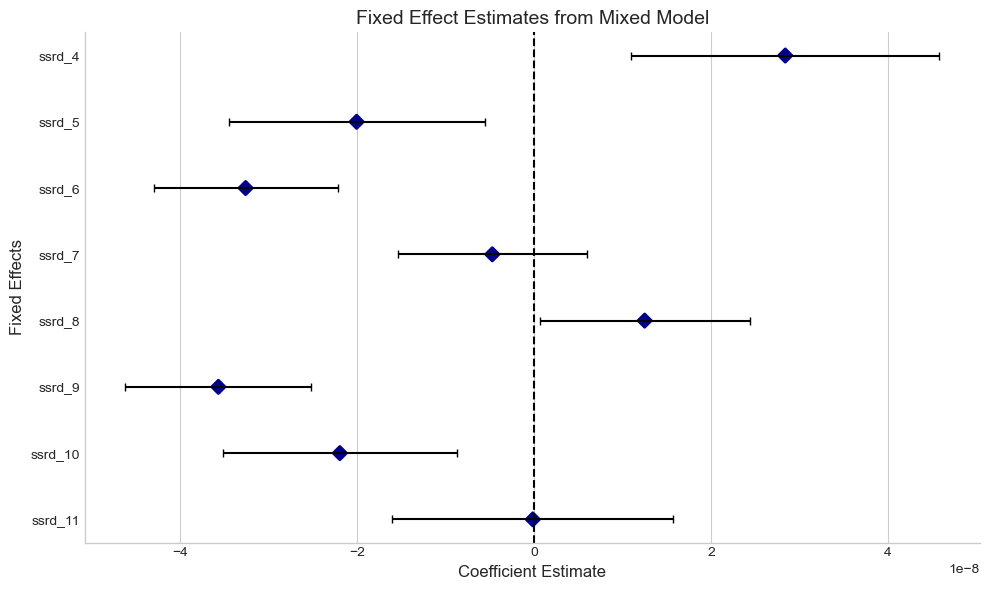

C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='month', inplace=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_ef

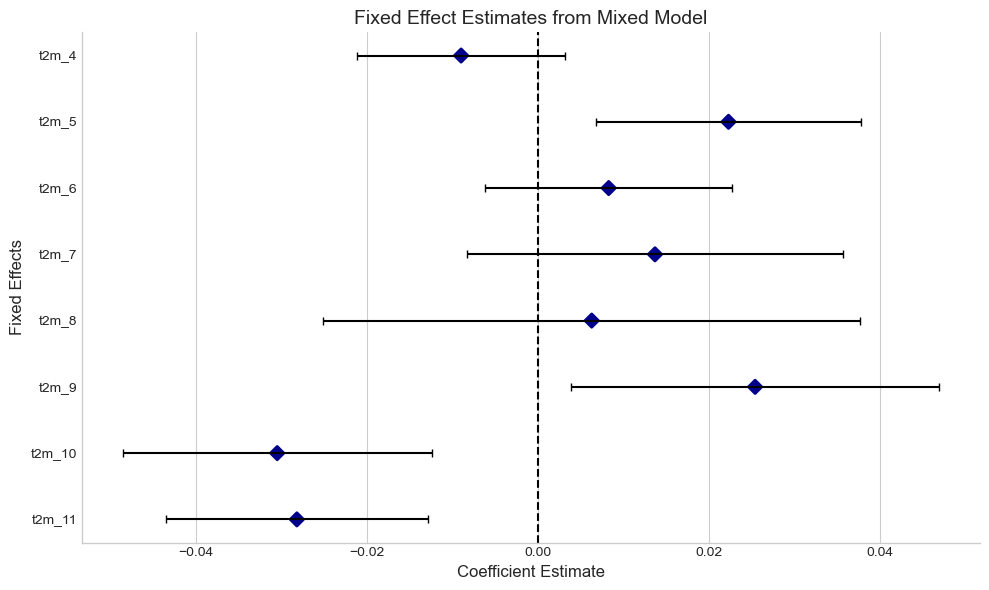

C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='month', inplace=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_12460\2521268247.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_ef

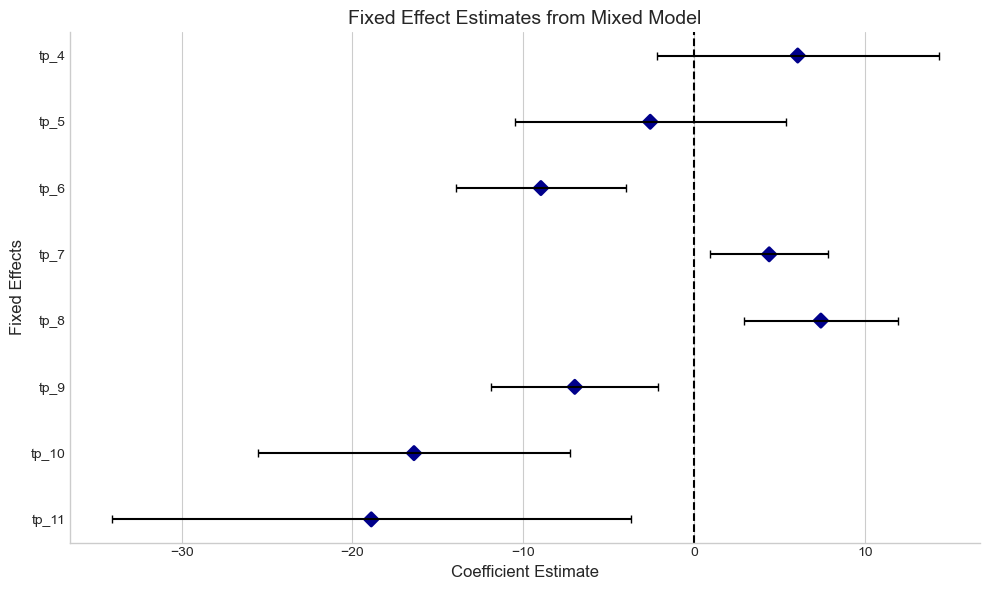

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'lm' is your mixed effects model object and it has a method to get the summary dataframe
# For example, using statsmodels it would look something like this:
# fixed_effects = lm.fe_params
# conf_int = lm.conf_int()


# Here's a mock-up of how you might retrieve the data
fixed_effects = pd.DataFrame({
    'Estimate': lm.fe_params,
    #"p value": lm.p_values,
    'Lower CI': lm.conf_int()[0],
    'Upper CI': lm.conf_int()[1]
})

# Reset index to get the variable names into a column
fixed_effects.reset_index(inplace=True)
fixed_effects.columns = ['Variable', 'Estimate', 'Lower CI', 'Upper CI'] #'p value' 

# Set the style for the plot
plt.style.use('seaborn-whitegrid')



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'lm' is your mixed effects model object
# ...

# Function to create the dot-and-whisker plot
def plot_fixed_effects(subset_fixed_effects):
    # Add month column by extracting month from variable, split by _ and convert to int
    subset_fixed_effects['month'] = subset_fixed_effects['Variable'].str.split('_').str[1].astype(int)
    # Sort by month
    subset_fixed_effects.sort_values(by='month', inplace=True)
    
    # Create the dot-and-whisker plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(x='Estimate', y='Variable', data=subset_fixed_effects,
                  join=False, capsize=0.1, color='darkblue', markers='D',
                  errwidth=1, ci=None)

    # Draw the error bars manually
    # Draw the error bars manually since sns.pointplot doesn't support asymmetric error bars
    for index, row in subset_fixed_effects.iterrows():
        plt.errorbar(x=row['Estimate'], y=index, xerr=[[row['Estimate'] - row['Lower CI']], [row['Upper CI'] - row['Estimate']]],
                    fmt='none', c='black', capsize=3)

    # Add horizontal line at zero
    plt.axvline(x=0, color='black', linestyle='--')

    # Customize the plot
    plt.xlabel('Coefficient Estimate', fontsize=12)
    plt.ylabel('Fixed Effects', fontsize=12)
    plt.title('Fixed Effect Estimates from Mixed Model', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Here's a mock-up of how you might retrieve the data
fixed_effects = pd.DataFrame({
    'Estimate': lm.fe_params,
    'Lower CI': lm.conf_int()[0],
    'Upper CI': lm.conf_int()[1]
})

# Reset index to get the variable names into a column
fixed_effects.reset_index(inplace=True)
fixed_effects.columns = ['Variable', 'Estimate', 'Lower CI', 'Upper CI']

# Plotting different subsets
slices = [(2, 10), (10, 18), (18, None)]  # Define slices as tuples (start, end)
for start, end in slices:
    subset = fixed_effects.iloc[start:end] if end is not None else fixed_effects.iloc[start:]
    subset['month'] = subset['Variable'].str.split('_').str[1].astype(int)
    subset.sort_values(by='month', inplace=True)
    subset = subset.reset_index()
    plot_fixed_effects(subset)

### 4.5 Visualize Yield Trend for India

In [ ]:
# computing the residual and marginal r squared of the full model

result = lm
var_resid = result.scale
var_random_effect = float(result.cov_re.iloc[0])
var_fixed_effect = result.predict().var()

total_var = var_fixed_effect + var_random_effect + var_resid
marginal_r2 = var_fixed_effect / total_var
conditional_r2 = (var_fixed_effect + var_random_effect) / total_var
marginal_r2

0.021220267542566302

In [ ]:
conditional_r2

0.8566809307349403

In [ ]:
# mean by year and model
# drop gid 2
result_total_df = result_district_df.drop(columns=['GID_2'])
result_total_df = result_total_df.groupby(['year', 'model']).mean().reset_index()
result_total_df

,year,model,yield
0,2000,ERA5,2.124281
1,2001,ERA5,2.122917
2,2002,ERA5,2.094622
3,2003,ERA5,2.193848
4,2004,ERA5,2.130912
...,...,...,...
583,2100,INM-CM4-8,2.032049
584,2100,INM-CM5-0,2.110506
585,2100,MIROC6,2.062894
586,2100,MPI-ESM1-2-LR,2.166996


C:\Users\elias\AppData\Local\Temp\ipykernel_12556\1623072517.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(years, p(years), "r--", label='Average future trend', linewidth=3, color='black')


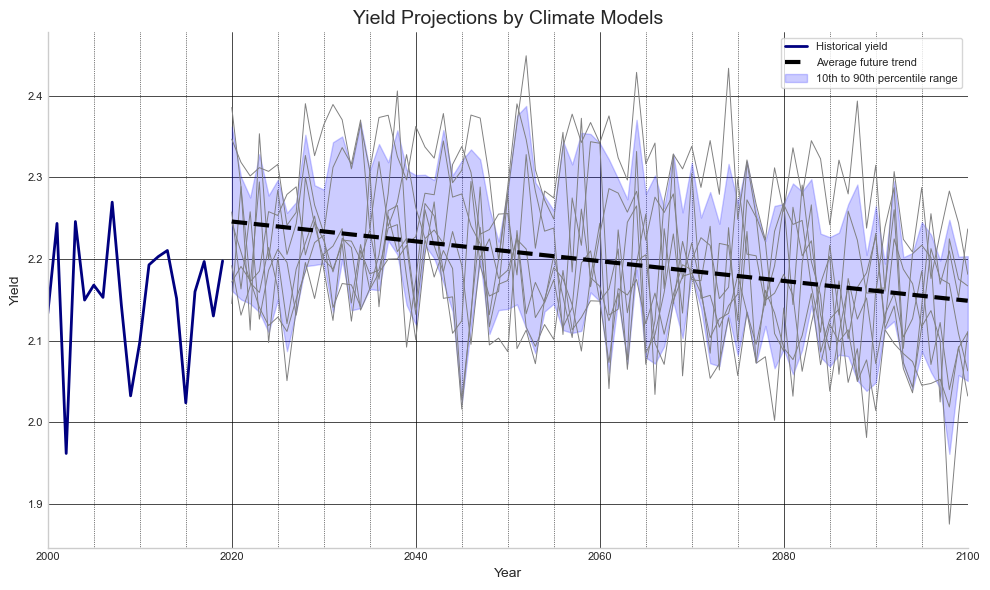

In [ ]:
# Line plot of climate variables over time

# Assuming result_total_df is your DataFrame and is already loaded
# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot each model in a very light gray and thin line
for model in result_total_df["model"].unique():
    if model != 'ERA5':
        ax.plot(result_total_df[result_total_df["model"] == model]["year"],
                result_total_df[result_total_df["model"] == model]["yield"],
                color='gray', alpha=1, linewidth=0.7)

# Calculate and plot the average trend line across all models except ERA5
years = result_total_df[result_total_df["model"] != 'ERA5']["year"].unique()
avg_trend = result_total_df[result_total_df["model"] != 'ERA5'].groupby('year')['yield'].mean()
z = np.polyfit(years, avg_trend, 1)
p = np.poly1d(z)


# Calculate the main trend for all models except ERA5
main_trend_df = result_total_df[result_total_df["model"] != 'ERA5']
grouped = main_trend_df.groupby('year')['yield']
percentiles = grouped.quantile([0.1, 0.9]).unstack(level=1)

# Plot the shaded percentile range
ax.fill_between(percentiles.index, percentiles[0.1], percentiles[0.9], 
                color='blue', alpha=0.2, label='10th to 90th percentile range')

# Highlight the ERA5 historical data
era5_data = df_yield_weather['Yield_t_ha_detrended'].groupby(df_yield_weather['year']).mean().reset_index()
era5_data = era5_data[era5_data["year"] <= 2019]
ax.plot(era5_data['year'], era5_data['Yield_t_ha_detrended'], label='Historical yield', color='navy', linewidth=2)


ax.plot(years, p(years), "r--", label='Average future trend', linewidth=3, color='black')

# Customize the plot
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Yield', fontsize=10)
ax.set_title('Yield Projections by Climate Models', fontsize=14)
ax.legend(frameon=True, loc='best', fontsize=8)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(axis='both', which='major', labelsize=8)

# Removing top and right borders for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the limit for x-axis to avoid having too much empty space
ax.set_xlim([result_total_df['year'].min(), result_total_df['year'].max()])

# Show the plot
plt.tight_layout()
plt.show()



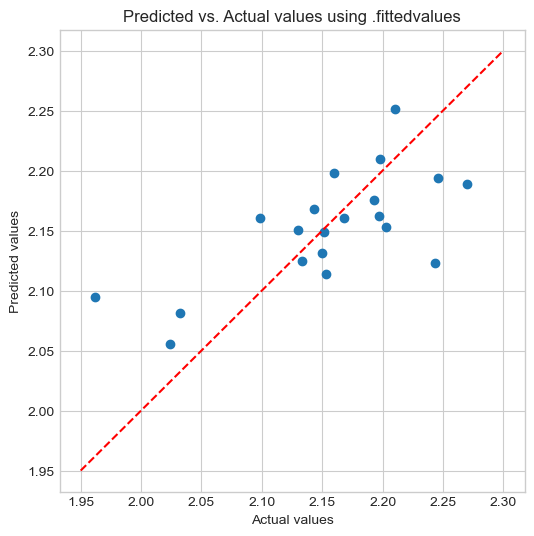

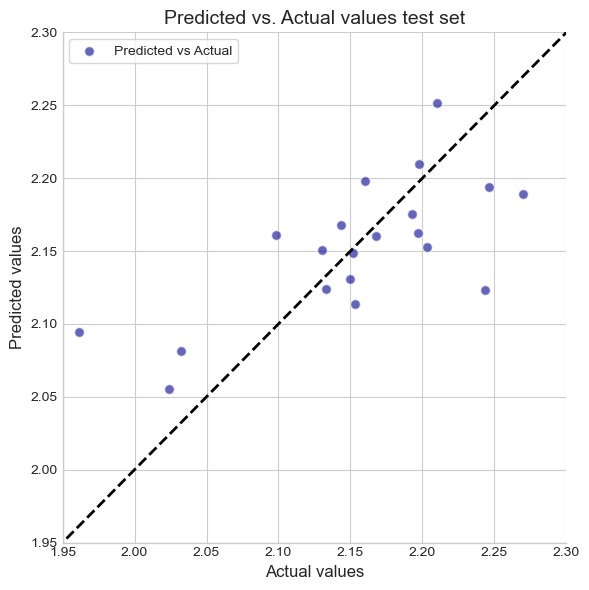

0.48084811241140424


In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(era5_data['Yield_t_ha_detrended'], result_total_df[(result_total_df["model"] == 'ERA5') & (result_total_df["year"]<=2019)]["yield"])
plt.plot([1.95, 2.3], [1.95, 2.3], color = 'red', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values using .fittedvalues')
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(era5_data['Yield_t_ha_detrended'], result_total_df[(result_total_df["model"] == 'ERA5') & (result_total_df["year"]<=2019)]["yield"], alpha=0.6, edgecolors='w', s=50, color='darkblue', label='Predicted vs Actual')
# add diagonal line
plt.plot([0, 5], [0, 5], color='black', lw=2, linestyle='--')
plt.xlim(1.95, 2.3)
plt.ylim(1.95, 2.3)
# Customize the plot
plt.xlabel('Actual values', fontsize=12)
plt.ylabel('Predicted values', fontsize=12)
plt.title('Predicted vs. Actual values test set', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=10)
# Remove the top and right spines
sns.despine()
# Show the plot with a tight layout
plt.tight_layout()
plt.show()

# r squared

print(sklearn.metrics.r2_score(era5_data['Yield_t_ha_detrended'], result_total_df[(result_total_df["model"] == 'ERA5') & (result_total_df["year"]<=2019)]["yield"]))

In [ ]:
# plot temperature from india_districts_total_pivot by model and year
# first group by model and year
india_districts_total_pivot_grouped = india_districts_total_pivot.groupby(['model', 'year']).mean().reset_index()

# take the mean for all month of each variable
# we need to split on "_"
india_districts_total_pivot_grouped.columns = india_districts_total_pivot_grouped.columns.str.split('_').str[0]
# now take the mean of columnns with the same name
for variable in ['t2m', 'tp', 'ssrd']:
    india_districts_total_pivot_grouped[variable+ "total"] = india_districts_total_pivot_grouped.filter(like=variable).mean(axis=1)

india_districts_total_pivot_grouped

,model,year,ssrd,ssrd,ssrd,ssrd,ssrd,ssrd,ssrd,ssrd,...,tp,tp,tp,tp,tp,tp,tp,t2mtotal,tptotal,ssrdtotal
0,ACCESS-CM2,2020,2.370725e+07,2.355458e+07,1.916201e+07,1.645992e+07,1.596418e+07,1.580814e+07,1.663693e+07,1.456705e+07,...,0.117383,0.299482,0.328602,0.178178,0.334984,0.066804,0.046067,27.180759,0.177064,1.823251e+07
1,ACCESS-CM2,2021,2.417759e+07,2.363642e+07,1.952394e+07,1.521144e+07,1.512923e+07,1.545651e+07,1.659746e+07,1.555860e+07,...,0.097579,0.235597,0.593836,0.294682,0.213327,0.194244,0.026509,27.026228,0.213533,1.816140e+07
2,ACCESS-CM2,2022,2.359890e+07,2.416120e+07,1.869655e+07,1.526019e+07,1.482249e+07,1.545472e+07,1.644341e+07,1.506806e+07,...,0.071758,0.362594,0.425096,0.311509,0.288643,0.151236,0.059949,26.050952,0.219620,1.793819e+07
3,ACCESS-CM2,2023,2.207305e+07,2.293913e+07,1.956736e+07,1.690278e+07,1.598117e+07,1.635979e+07,1.595645e+07,1.551100e+07,...,0.148020,0.174540,0.267957,0.213066,0.154755,0.154103,0.037711,27.520039,0.158930,1.816134e+07
4,ACCESS-CM2,2024,2.384772e+07,2.314301e+07,1.913328e+07,1.442053e+07,1.501221e+07,1.674503e+07,1.630898e+07,1.407574e+07,...,0.228895,0.118395,0.628825,0.266489,0.098624,0.108247,0.064338,26.559046,0.197886,1.783581e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,NESM3,2096,2.308285e+07,2.393054e+07,1.705364e+07,1.316669e+07,1.360747e+07,1.576026e+07,1.580681e+07,1.486563e+07,...,0.074551,0.478108,0.561070,0.495606,0.341587,0.148715,0.064995,30.477969,0.282699,1.715924e+07
584,NESM3,2097,2.312662e+07,2.266411e+07,2.002258e+07,1.432515e+07,1.330428e+07,1.510272e+07,1.581426e+07,1.543294e+07,...,0.454859,0.144853,0.664772,0.481947,0.276475,0.173030,0.041522,29.965688,0.292824,1.747408e+07
585,NESM3,2098,2.439761e+07,2.377585e+07,2.171392e+07,1.609807e+07,1.435499e+07,1.569097e+07,1.590889e+07,1.648431e+07,...,0.065937,0.072737,0.250367,0.425012,0.235558,0.157629,0.031955,31.402280,0.156082,1.855308e+07
586,NESM3,2099,2.460065e+07,2.341448e+07,2.050539e+07,1.558488e+07,1.367392e+07,1.594705e+07,1.722728e+07,1.553914e+07,...,0.150746,0.117852,0.263269,0.533739,0.257537,0.158765,0.069883,31.474968,0.194792,1.831160e+07


C:\Users\elias\AppData\Local\Temp\ipykernel_17956\1583155672.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(future_years, p(future_years), "r--", label='Main trend', linewidth=2, color='black')
C:\Users\elias\AppData\Local\Temp\ipykernel_17956\1583155672.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(future_years, p(future_years), "r--", label='Main trend', linewidth=2, color='black')
C:\Users\elias\AppData\Local\Temp\ipykernel_17956\1583155672.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(future_years, p(future_years), "r--", label='Main trend', linewidth=2, color='black')


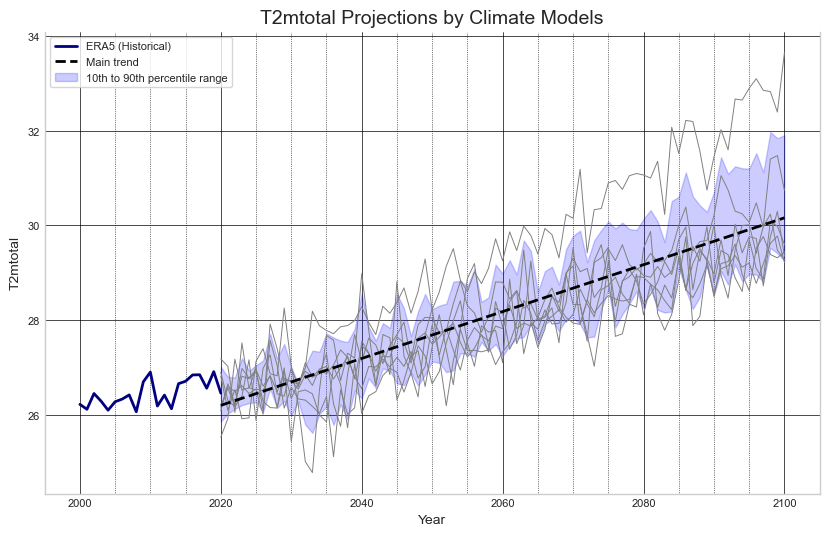

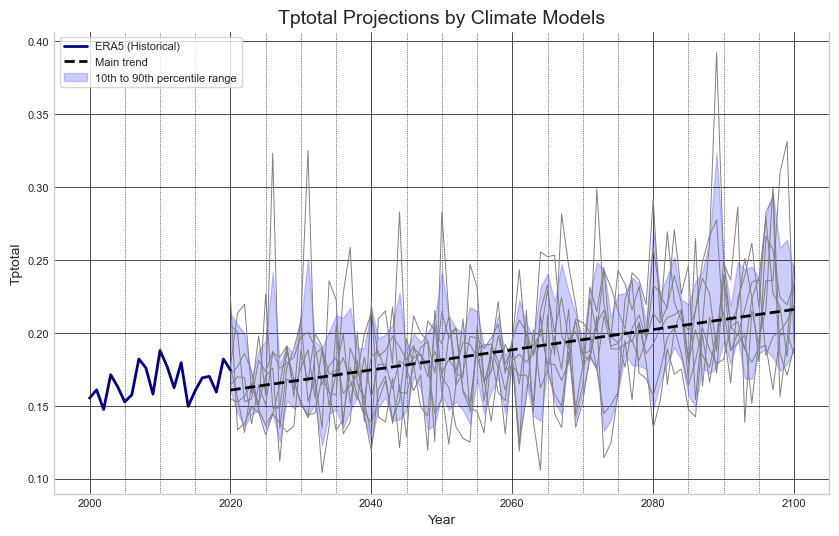

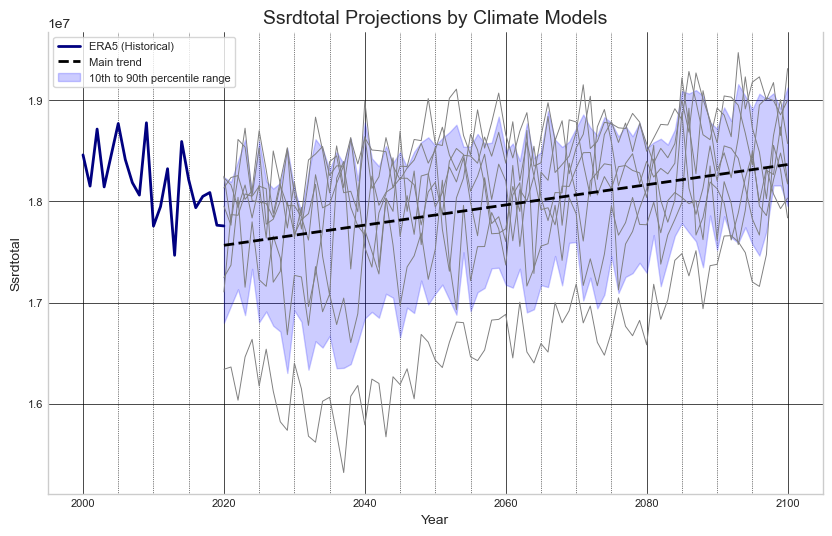

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Assuming india_districts_total_pivot_grouped is your DataFrame and is already loaded
# Set the style for the plot
plt.style.use('seaborn-whitegrid')

# Define the list of variables to plot
variables = ['t2mtotal', 'tptotal', 'ssrdtotal']

# Loop over each variable to create a separate plot
for variable in variables:
    # Initialize the plot for the current variable
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot each model's line in gray except ERA5
    for model in india_districts_total_pivot_grouped["model"].unique():
        subset = india_districts_total_pivot_grouped[india_districts_total_pivot_grouped["model"] == model]
        if model != 'ERA5':
            ax.plot(subset["year"], subset[variable], color='gray', alpha=1, linewidth=0.7, label='_nolegend_')

    # Highlight the ERA5 historical data
    era5_subset = india_districts_total_pivot_grouped[india_districts_total_pivot_grouped["model"] == 'ERA5']
    ax.plot(era5_subset["year"], era5_subset[variable], label='ERA5 (Historical)', color='navy', linewidth=2)

    # Calculate the main trend line for future projections across all models except ERA5
    future_subset = india_districts_total_pivot_grouped[(india_districts_total_pivot_grouped["model"] != 'ERA5') & (india_districts_total_pivot_grouped["year"] > 2019)]
    future_years = future_subset["year"].unique()
    future_avg_trend = future_subset.groupby('year')[variable].mean()
    z = np.polyfit(future_years, future_avg_trend, 1)
    p = np.poly1d(z)
    ax.plot(future_years, p(future_years), "r--", label='Main trend', linewidth=2, color='black')

    # Calculate the 10th to 90th percentile range for the shaded area
    grouped = future_subset.groupby('year')[variable]
    percentiles = grouped.quantile([0.1, 0.9]).unstack(level=1)
    ax.fill_between(percentiles.index, percentiles[0.1], percentiles[0.9], color='blue', alpha=0.2, label='10th to 90th percentile range')

    # Customize the plot
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel(variable.capitalize(), fontsize=10)
    ax.set_title(f'{variable.capitalize()} Projections by Climate Models', fontsize=14)
    ax.legend(frameon=True, loc='best', fontsize=8)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)




<AxesSubplot:ylabel='Frequency'>

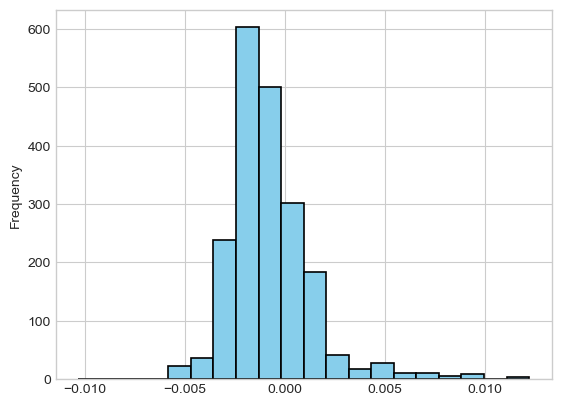

In [ ]:
import numpy as np
import pandas as pd

# Assuming result_district_df is your DataFrame and is already loaded

# Initialize a list to store district, model, and slope
slope_data = []

# Loop over each district
for district in result_district_df['GID_2'].unique():
    for model in result_district_df['model'].unique():
        # Select the subset of the DataFrame for the current district and model
        subset = result_district_df[(result_district_df['GID_2'] == district) & (result_district_df['model'] == model)]
        
        # Convert 'year' to numeric, ignoring errors
        year_numeric = pd.to_numeric(subset['year'], errors='coerce')
        yield_values = subset['yield']
        
        # Check if there are enough non-NaN values to fit a line
        if not year_numeric.isna().all() and len(year_numeric.dropna()) > 1:
            # Fit a polynomial regression line of degree 1 (linear trend) to the data
            z = np.polyfit(year_numeric.dropna(), yield_values[year_numeric.notna()], 1)
            
            # Extract the slope (average yield change per year)
            slope = z[0]
            
            # Append the district, model, and slope to the list
            slope_data.append({'GID_2': district, 'model': model, 'slope': slope})

# Create a new DataFrame from the slope data
slope_df = pd.DataFrame(slope_data)

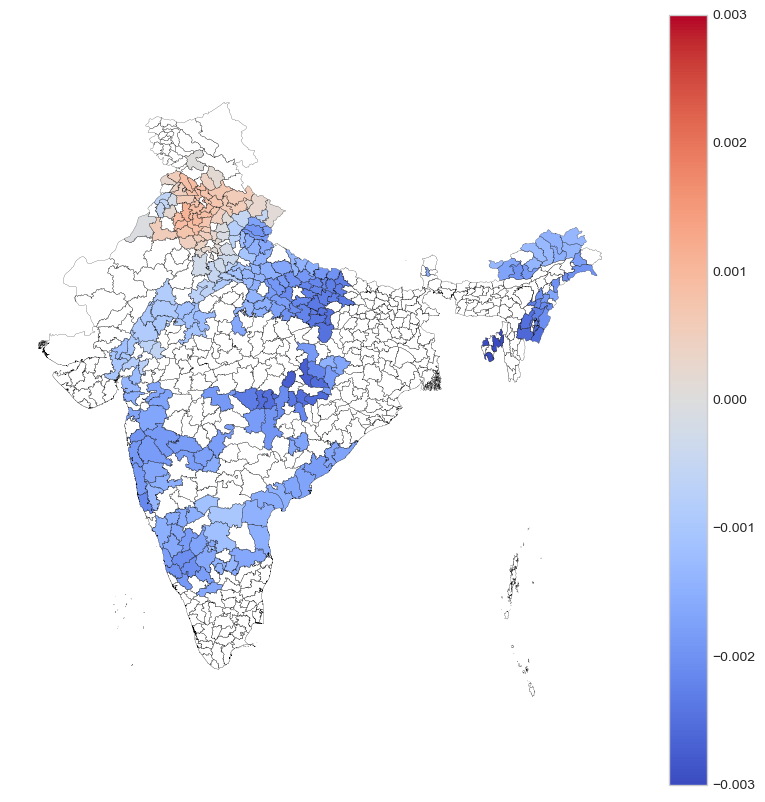

In [ ]:
# merge slope_grouped_df with india_districts_shapefile and plot
slope_grouped_df = slope_df[slope_df['model'] != 'ERA5'].groupby('GID_2').median().reset_index()
slope_grouped_df = india_districts_shapefile.merge(slope_grouped_df, on='GID_2')


# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
slope_grouped_df.plot(column='slope', ax=ax, legend=True, cmap = 'coolwarm', vmin=-0.003, vmax=0.003)
india_districts_shapefile.boundary.plot(edgecolor='black', linewidth=0.15, ax=ax)
# remove box and grid
ax.set_axis_off()

plt.show()

## 8. Visualization of Climate Trends

In [38]:
rice_nc = xr.open_dataset("data/CROPGRIDSv1.07_NC_maps/CROPGRIDSv1.07_NC_maps/CROPGRIDSv1.07_rice.nc")
rice_data = rice_nc["harvarea"]

In [39]:
# Filter crop data by raster cells larger than 100 and make data binary
rice_over_100 = xr.where(rice_data > 100, 1, 0)

# Clip the data to India's borders
rice_over_100_clip = rice_over_100.rio.write_crs(4326)
rice_over_100_clip = rice_over_100_clip.rio.clip(india_shapefile.geometry)
rice_over_100_clip = xr.where(rice_over_100_clip < 0, 0, rice_over_100_clip)
# rename dimensions to x and y
rice_over_100_clip = rice_over_100_clip.rename({'lon': 'x', 'lat': 'y'})

# Save the clipped data as a TIFF file
rice_over_100_clip.rio.to_raster("data/processed/crop_binary.tif")
polygonized_crop_gdf = convert_raster_to_vectors(rio.open("data/processed/crop_binary.tif"))

smoothed_polygons = polygonized_crop_gdf.copy()
smoothed_polygons["geometry"] = [geom.buffer(0.05, join_style=1).buffer(-0.05, join_style=1) for geom in polygonized_crop_gdf["geometry"]]

# We filter out the polygons that are not rice-growing areas
smoothed_polygons = smoothed_polygons[smoothed_polygons["value"] == 1.0]

2024-02-09 18:26:31,529 INFO Ring Self-intersection at or near point 77.549998962245311 8.3499999252268644
2024-02-09 18:26:31,536 INFO Ring Self-intersection at or near point 78.049998988418196 15.799999547559162
2024-02-09 18:26:31,545 INFO Ring Self-intersection at or near point 81.599999174245639 18.599999405616938
2024-02-09 18:26:31,559 INFO Ring Self-intersection at or near point 83.999999299875469 23.049999180030191
2024-02-09 18:26:31,563 INFO Ring Self-intersection at or near point 73.149998731923972 22.349999215515744
2024-02-09 18:26:31,567 INFO Ring Self-intersection at or near point 92.899999765752725 22.899999187634236
2024-02-09 18:26:31,582 INFO Ring Self-intersection at or near point 78.399999006739208 27.199998969651539
2024-02-09 18:26:31,588 INFO Ring Self-intersection at or near point 80.149999098344281 29.249998865729552
2024-02-09 18:26:31,650 INFO Ring Self-intersection at or near point 79.149999045998527 26.049999027949234
2024-02-09 18:26:31,654 INFO Ring Sel

In [40]:
west_bnd, south_bnd, east_bnd, north_bnd = india_shapefile.bounds.iloc[0]

india_geometry = india_shapefile.geometry

# Define the outer boundary box
outer_box = Polygon([(west_bnd, north_bnd), (west_bnd, south_bnd), (east_bnd, south_bnd), (east_bnd, north_bnd)]).buffer(100)

# Subtract India's geometry from the outer box to create inverse shape
difference = outer_box
for geometry in india_geometry.geometry:
    difference = difference.difference(geometry)

# Create a GeoDataFrame for the inverse country shape
inv_country_gdf = gpd.GeoDataFrame(geometry=[difference])

In [41]:
scenario = "ssp585"
climate_data_aggregate_median = xr.Dataset()

# Assuming 'variables' is a list of your variables like ['txx']
for variable in ['t2m', 'tp', 'ssrd']:
    # Combine model-specific variables into a single DataArray
    combined_data = xr.concat(
        [climate_data_aggregate[f"{variable}_{model}_{scenario}"] for model in models],
        dim='model'
    )

    # Compute the median across models
    median_data = combined_data.median(dim='model')

    # You can now add this median data to your aggregate dataset
    climate_data_aggregate_median[f"{variable}_median"] = median_data

In [42]:
# select months 4 to 11
for variable in ['t2m_median', 'tp_median', 'ssrd_median']:
    climate_data_aggregate_median[variable] = climate_data_aggregate_median[variable].where(
        (climate_data_aggregate_median[variable].time.dt.month >= 4) &
        (climate_data_aggregate_median[variable].time.dt.month <= 11),
        drop=True
    )

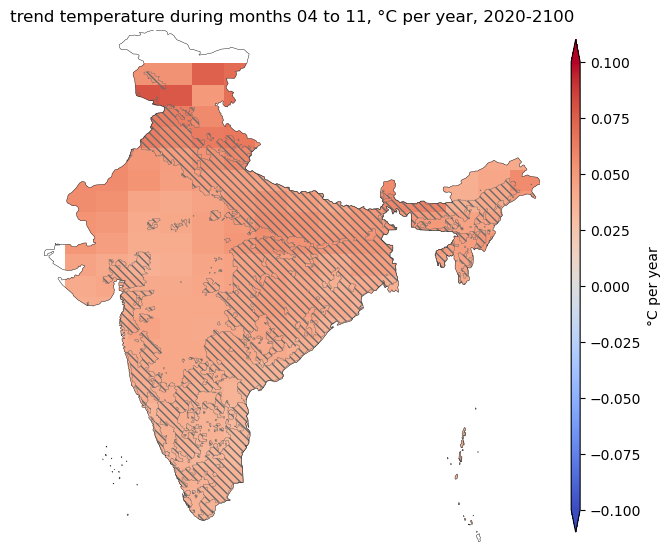

In [43]:
trend = climate_data_aggregate_median["t2m_median"].polyfit(dim="time", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"].rio.write_crs(4326)
# change trend from ns to years
trend = trend * 365.25 * 24 * 60 * 60 * 1e9 

fig, ax = plt.subplots(figsize=(8, 8))

# Plot temperature data
trend.plot(ax=ax, cmap="coolwarm", vmin=-0.1, vmax=0.1, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# Overlay India's boundaries and inverse country shape
india_shapefile.boundary.set_crs(4326).plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)


cmap = mpl.cm.coolwarm  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='°C per year', aspect=50, pad=0.05, shrink=0.8, extend='both')


# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend temperature during months 04 to 11, °C per year, 2020-2100")
ax.set_axis_off()

# Display the plot
plt.show()

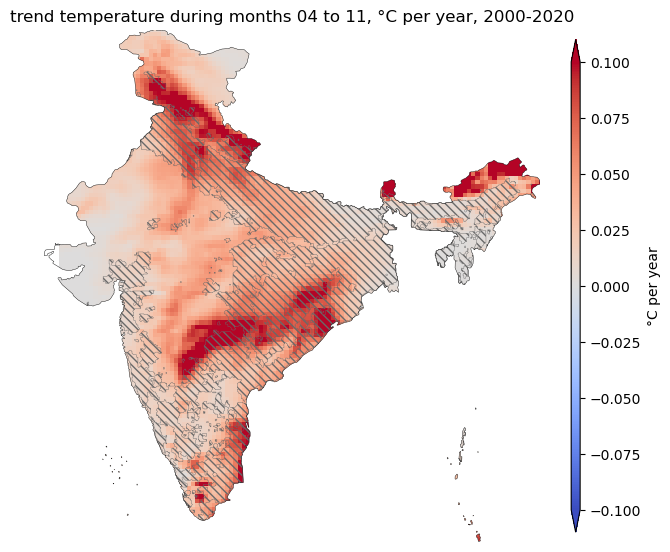

In [44]:
trend = era5_ds["t2m"].where(
    (era5_ds["t2m"].time.dt.month >= 4) & (era5_ds["t2m"].time.dt.month <= 11),
    drop=True
).polyfit(dim="time", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"]
# change trend from ns to years
trend = trend * 365.25 * 24 * 60 * 60 * 1e9 

fig, ax = plt.subplots(figsize=(8, 8))

# Plot temperature data
era5_ds.isel(time=0).tp.plot(ax=ax, cmap="coolwarm", vmin=-0.1, vmax=0.1, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# Overlay India's boundaries and inverse country shape
india_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)


cmap = mpl.cm.coolwarm  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='°C per year', aspect=50, pad=0.05, shrink=0.8, extend='both')

# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend temperature during months 04 to 11, °C per year, 2000-2020")
ax.set_axis_off()

# Display the plot
plt.show()

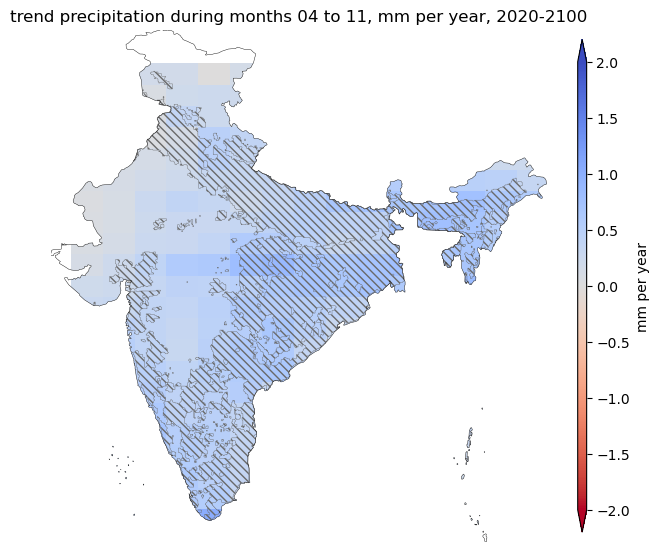

In [45]:
trend = climate_data_aggregate_median["tp_median"].polyfit(dim="time", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"]
# change trend from ns to years
trend = trend * 365.25 * 24 * 60 * 60 * 1e9 *1000

fig, ax = plt.subplots(figsize=(8, 8))

# Plot temperature data
trend.plot(ax=ax, cmap="coolwarm_r", vmin=-2, vmax=2, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# Overlay India's boundaries and inverse country shape
india_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)


cmap = mpl.cm.coolwarm_r  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='mm per year', aspect=50, pad=0.05, shrink=0.8, extend='both')


# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend precipitation during months 04 to 11, mm per year, 2020-2100")
# remove box
ax.set_axis_off()

# Display the plot
plt.show()

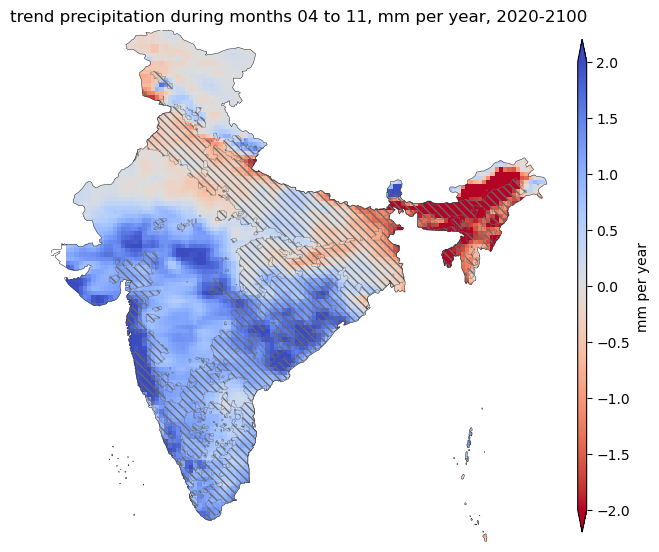

In [46]:
trend = era5_ds["tp"].where(
    (era5_ds["tp"].time.dt.month >= 4) & (era5_ds["tp"].time.dt.month <= 11),
    drop=True
).polyfit(dim="time", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"]
# change trend from ns to years
trend = trend * 365.25 * 24 * 60 * 60 * 1e9 *1000

fig, ax = plt.subplots(figsize=(8, 8))

# Plot temperature data
trend.plot(ax=ax, cmap="coolwarm_r", vmin=-2, vmax=2, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# Overlay India's boundaries and inverse country shape
india_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)



cmap = mpl.cm.coolwarm_r  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='mm per year', aspect=50, pad=0.05, shrink=0.8, extend='both')


# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend precipitation during months 04 to 11, mm per year, 2020-2100")
# remove box
ax.set_axis_off()

# Display the plot
plt.show()

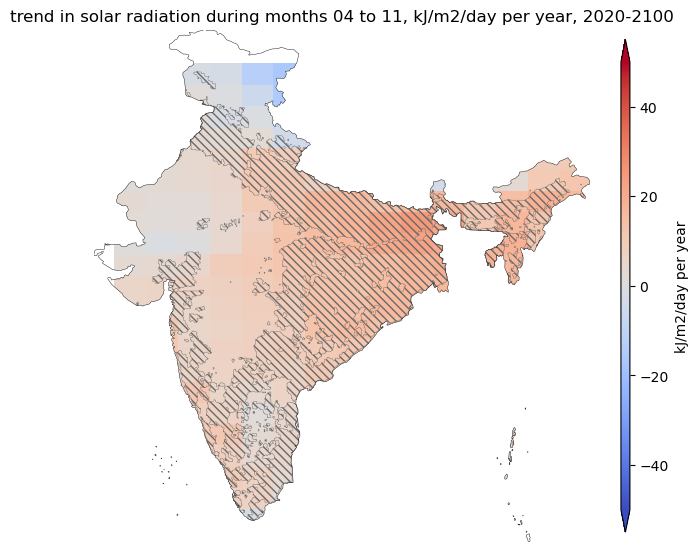

In [47]:
trend = climate_data_aggregate_median["ssrd_median"].polyfit(dim="time", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"]
# change trend from ns to years
trend = trend * 365.25 * 24 * 60 * 60 * 1e6

fig, ax = plt.subplots(figsize=(8, 8))

# Plot temperature data
trend.plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# Overlay India's boundaries and inverse country shape
india_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)

cmap = mpl.cm.coolwarm  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=-50, vmax=50)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='kJ/m2/day per year', aspect=50, pad=0.05, shrink=0.8, extend='both')


# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend in solar radiation during months 04 to 11, kJ/m2/day per year, 2020-2100")
ax.set_axis_off()

# Display the plot
plt.show()

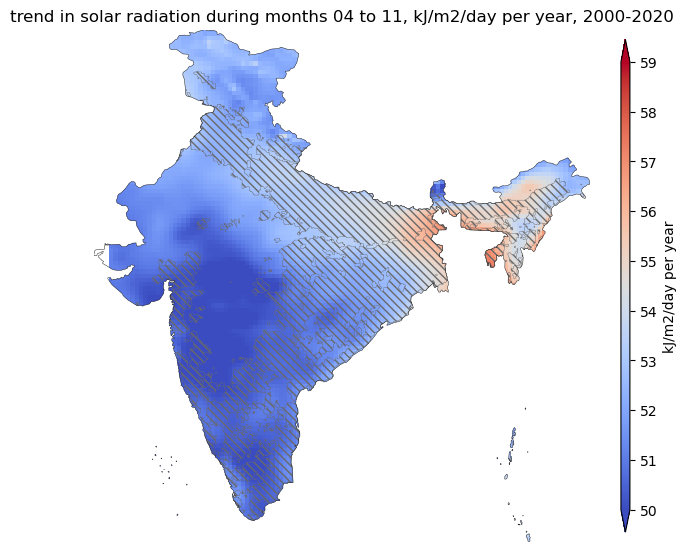

In [48]:
trend = era5_ds["ssrd"].where(
    (era5_ds["ssrd"].time.dt.month >= 4) & (era5_ds["ssrd"].time.dt.month <= 11),
    drop=True
).polyfit(dim="time", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"]
# change trend from ns to years
trend = trend * 365.25 * 24 * 60 * 60 * 1e6

fig, ax = plt.subplots(figsize=(8, 8))

# Plot temperature data
trend.plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# Overlay India's boundaries and inverse country shape
india_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)

cmap = mpl.cm.coolwarm  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=59, vmax=50)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='kJ/m2/day per year', aspect=50, pad=0.05, shrink=0.8, extend='both')

# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend in solar radiation during months 04 to 11, kJ/m2/day per year, 2000-2020")
ax.set_axis_off()

# Display the plot
plt.show()

In [49]:
climate_median_df = climate_data_aggregate_median.sel(time = slice("2020-01-01", "2100-12-01"))
climate_median_df = climate_median_df.sel(time = climate_median_df['time.month'].isin([4, 5, 6, 7, 8, 9, 10, 11])).to_dataframe() 

# remove _median in column names
climate_median_df.columns = climate_median_df.columns.str.replace('_median', '')

climate_median_df = climate_median_df.reset_index()
climate_median_df = climate_median_df.drop(columns=['height'])
climate_median_df = climate_median_df.pivot(index=['y', 'x'], columns='time', values=climate_median_df.columns[3:]).reset_index()
climate_median_df.columns = climate_median_df.columns.map('{0[0]}_{0[1]}'.format)
climate_median_df = climate_median_df.rename(columns={'x_': 'x', 'y_': 'y'})
climate_median_df = climate_median_df.melt(id_vars=['x', 'y'], var_name='id', value_name='value')
climate_median_df['time'] = climate_median_df['id'].str.split('_').str[1].str.split(' ').str[0]
climate_median_df['month'] = climate_median_df['time'].str.split('-').str[1]
climate_median_df['year'] = climate_median_df['time'].str.split('-').str[0]
climate_median_df['variable'] = climate_median_df['id'].str.split('_').str[0]
# subtract 273.15 to convert to °C if t2m
climate_median_df['value'] = np.where(climate_median_df['variable'] == 't2m', climate_median_df['value'] - 273.15, climate_median_df['value'])
climate_median_df["variable"] = climate_median_df["variable"] + "_" + climate_median_df["month"]
climate_median_df["variable"] = climate_median_df["variable"].str.replace('_0', '_')
climate_median_df = climate_median_df.drop(columns=['id', 'time'])
climate_median_df = climate_median_df.pivot(index=['x', 'y', 'year'], columns='variable', values='value').reset_index()

climate_median_df

variable,x,y,year,ssrd_10,ssrd_11,ssrd_4,ssrd_5,ssrd_6,ssrd_7,ssrd_8,...,t2m_8,t2m_9,tp_10,tp_11,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9
0,68.4375,8.125,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68.4375,8.125,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68.4375,8.125,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68.4375,8.125,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68.4375,8.125,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,96.5625,34.375,2096,15875349.0,14340207.0,23447084.0,23775634.0,26028728.0,25932040.0,24105744.0,...,12.292139,11.221033,0.094047,0.040916,0.053648,0.074352,0.141509,0.123291,0.122604,0.144297
28508,96.5625,34.375,2097,15786468.0,14627307.0,22250392.0,24587696.0,24758358.0,24696678.0,23784756.0,...,11.726404,9.202081,0.064093,0.025771,0.083698,0.109074,0.131605,0.130784,0.122189,0.111689
28509,96.5625,34.375,2098,16530081.0,14223832.0,23870928.0,24807816.0,24563466.0,23142232.0,21250012.0,...,11.871729,9.526819,0.058744,0.017492,0.045088,0.103807,0.135737,0.077292,0.105024,0.111917
28510,96.5625,34.375,2099,17613110.0,13705680.0,20637306.0,22616312.0,25036804.0,26053752.0,22057386.0,...,13.231104,10.338556,0.073567,0.031040,0.077141,0.105628,0.169991,0.088395,0.085687,0.112453


In [50]:
# apply linear model
yield_raster_df = climate_median_df[[ 'y', 'x', 'year']]
yield_raster_df['yield'] = lm.predict(climate_median_df[climate_median_df.columns[3:]])

# transform resulting dataframe into a xr dataset
yield_ds = yield_raster_df.set_index([ 'y', 'x', 'year']).to_xarray()

yield_ds

C:\Users\elias\AppData\Local\Temp\ipykernel_16968\1819151154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yield_raster_df['yield'] = lm.predict(climate_median_df[climate_median_df.columns[3:]])


<xarray.Dataset>
Dimensions:  (y: 22, x: 16, year: 81)
Coordinates:
  * y        (y) float64 8.125 9.375 10.62 11.88 ... 30.62 31.88 33.12 34.38
  * x        (x) float64 68.44 70.31 72.19 74.06 ... 90.94 92.81 94.69 96.56
  * year     (year) object '2020' '2021' '2022' '2023' ... '2098' '2099' '2100'
Data variables:
    yield    (y, x, year) float64 nan nan nan nan ... 1.925 1.997 1.944 2.022

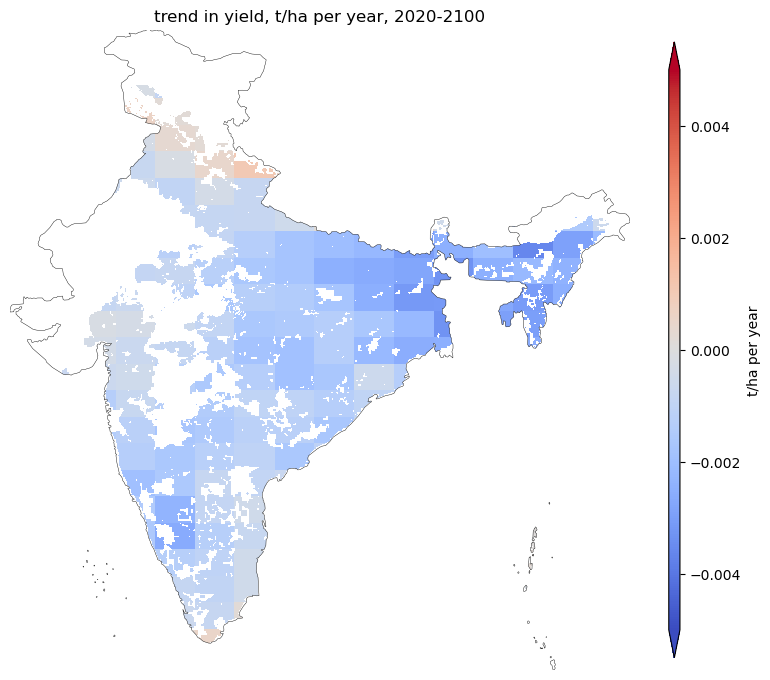

In [51]:
trend = yield_ds["yield"].polyfit(dim="year", deg=1, skipna=True).sel(degree=1)["polyfit_coefficients"].rio.write_crs(4326)
# change trend from ns to years
trend = trend #* 365.25 * 24 * 60 * 60 * 1e6

clipped_rice_data = rice_data.rio.write_crs(4326).rio.clip_box(*trend.rio.bounds())
trend = trend.interp(x=clipped_rice_data['lon'], y=clipped_rice_data['lat'], method= "nearest")
trend = trend.where(clipped_rice_data > 10)

fig, ax = plt.subplots(figsize=(10, 10))




# Plot temperature data
trend.plot(ax=ax, cmap="coolwarm", vmin=-0.005, vmax=0.005, add_colorbar=False)
#climate_data_aggregate_median[f"{variable}_median"].isel(time=800).plot(ax=ax, cmap="coolwarm", vmin=-50, vmax=50)

# # Overlay India's boundaries and inverse country shape
india_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.3)
inv_country_gdf.plot(ax=ax, facecolor='white', edgecolor='none')

#smoothed_polygons.plot(ax=ax, edgecolor="dimgrey", color="none", hatch="\\\\\\\\", linewidth=0.3)
cmap = mpl.cm.coolwarm  # Consider if this is the best choice for your data
norm = mpl.colors.Normalize(vmin=-0.005, vmax=0.005)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='t/ha per year', aspect=50, pad=0.05, shrink=0.8, extend='both')

# Set geographical bounds and title for the plot
ax.set(xlim=(west_bnd, east_bnd), ylim=(south_bnd, north_bnd), title="trend in yield, t/ha per year, 2020-2100")
ax.set_axis_off()

# Display the plot
plt.show()